In [1]:
import numpy as np
import pandas as pd
import time
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.interpolate import interp1d
from itertools import combinations

In [2]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from generators.GA.TestGeneticAlgorithm import GeneticAlgorithm
from generators.Optimizers.GradientDescent import GradientDescent
from generators.Optimizers.GuidedLocalSearch import GuidedLocalSearch
from generators.Optimizers.HillClimbAlgorithm import HillClimbAlgorithm
from generators.Optimizers.MicrocanonicalAnnealing import MicrocanonicalAnnealing
from generators.Optimizers.ParticleSwarm import ParticleSwarm
from generators.Optimizers.SimulatedAnnealing import SimulatedAnnealing
from generators.Optimizers.TabuSearch import TabuSearch
from generators.Optimizers.ReactiveTabuSearch import ReactiveTabuSearch

In [58]:
kwargs = {
    'cnn_model_path': '../models/CNN_hp.keras',
    'masked_sequence': 'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTGGGCGGGAAGACAACTAGGGG',
    'early_stopping_patience': 100,
}
target_expressions = [0, 0.25, 0.5, 0.75, 1]

iterations = 5

optimizers = {
    'Genetic Algorithm': GeneticAlgorithm,
    'Gradient Descent': GradientDescent,
    'Guided Local Search': GuidedLocalSearch,
    'Hill Climb Algorithm': HillClimbAlgorithm,
    'Microcanonical Annealing': MicrocanonicalAnnealing,
    'Particle Swarm': ParticleSwarm,
    'Simulated Annealing': SimulatedAnnealing,
    'Tabu Search': TabuSearch,
    'Reactive Tabu Search': ReactiveTabuSearch,
}

### Testing Each Optimizer
---

In [4]:
# results = {
#     'optimizer': [],
#     'target_expression': [],
#     'iteration': [],
#     'sequence': [],
#     'prediction': [],
#     'error': [],
#     'runtime': [],
#     'prediction_history': [],
#     'error_history': [],
# }

# for optimizer_name, optimizer_class in optimizers.items():
#     for target_expression in target_expressions:
#         for i in range(1, iterations+1):

#             print(f'{optimizer_name} | target_expression = {target_expression} | Iteration {i}', end='\r')
        
#             convergence = []
            
#             obj = optimizer_class(
#                 **kwargs,
#                 target_expression=target_expression,
#                 seed=i,
#             )
#             start_time = time.time()
#             best_sequence, best_prediction, best_error = obj.run()
#             end_time = time.time()
#             prediction_history = obj.prediction_history

#             prediction_history = np.array(prediction_history).flatten()
#             error_history = np.array([abs(target_expression - pred) for pred in prediction_history])

#             results['optimizer'].append(optimizer_name)
#             results['target_expression'].append(target_expression)
#             results['iteration'].append(i)
#             results['sequence'].append(best_sequence)
#             results['prediction'].append(best_prediction)
#             results['error'].append(best_error)
#             results['runtime'].append(end_time - start_time)
#             results['prediction_history'].append(list(prediction_history))
#             results['error_history'].append(list(error_history))

#             print(' ' * 100, end='\r')
#     print(f'{optimizer_name} Complete')

# print('Evaluation Complete')

# results_df = pd.DataFrame(results)
# results_df.to_csv('Data/optimizer_evaluation_results.csv', index=False)
# results_df.head()

### Helper Functions
---

In [5]:
# Average each optimizer's results across iterations
def average_tests(df):
    def average_lists(series_of_lists):
        return np.mean(list(zip(*series_of_lists)), axis=1).tolist()

    grouped = df.groupby(['optimizer', 'target_expression'])

    return grouped.agg({
        'prediction': 'mean',
        'error': 'mean',
        'runtime': 'mean',
        'prediction_history': average_lists,
        'error_history': average_lists
    }).reset_index()

# Get the best test for each optimizer and target expression
def best_tests(df):
    grouped = df.groupby(['optimizer', 'target_expression'])
    best_rows = []
    for (optimizer, target), group in grouped:
        best_error_idx = group['error'].idxmin()
        best_row = group.loc[best_error_idx]

        best_rows.append({
            'optimizer': optimizer,
            'target_expression': target,
            'sequence': best_row['sequence'],
            'prediction': best_row['prediction'],
            'error': best_row['error'],
            'runtime': best_row['runtime'],
            'prediction_history': best_row['prediction_history'],
            'error_history': best_row['error_history'],
        })
    return pd.DataFrame(best_rows)

# returns a list of predictions that are the best seen so far for each iteration
def calculate_best_prediction_history(prediction_history, target_expression):
    best_prediction = prediction_history[0]
    best_prediction_history = [best_prediction]

    for i in range(1, len(prediction_history)):
        current_prediction = prediction_history[i]
        if abs(current_prediction - target_expression) < abs(best_prediction - target_expression):
            best_prediction = current_prediction
        best_prediction_history.append(best_prediction)
    
    return best_prediction_history


def dynamic_standardize_prediction_history(df):
    df['prediction_rate'] = df.apply(lambda row: len(row['prediction_history']) / row['runtime'], axis=1)
    max_rate = df['prediction_rate'].max()

    def resample_predictions(predictions, runtime, max_rate):
        num_points = int(max_rate * runtime)
        if num_points < 2:
            return [predictions[0]] * 2
        
        original_time = np.linspace(0, runtime, len(predictions))
        standardized_time = np.linspace(0, runtime, num_points)
        interpolated_predictions = np.interp(standardized_time, original_time, predictions)
        return interpolated_predictions.tolist()

    df['prediction_history'] = df.apply(
        lambda row: resample_predictions(row['prediction_history'], row['runtime'], max_rate),
        axis=1
    )
    return df

### Plotting
---

In [20]:
color_map = {
    'Genetic Algorithm' : 'tab:blue',
    'Gradient Descent' : 'grey',
    'Guided Local Search' : 'forestgreen',
    'Hill Climb Algorithm' : 'lightcoral',
    'Microcanonical Annealing' : 'darkturquoise',
    'Particle Swarm' : 'darkviolet',
    'Simulated Annealing' : 'darkorange',
    'Tabu Search' : 'red',
    'Reactive Tabu Search' : 'mediumspringgreen',
}

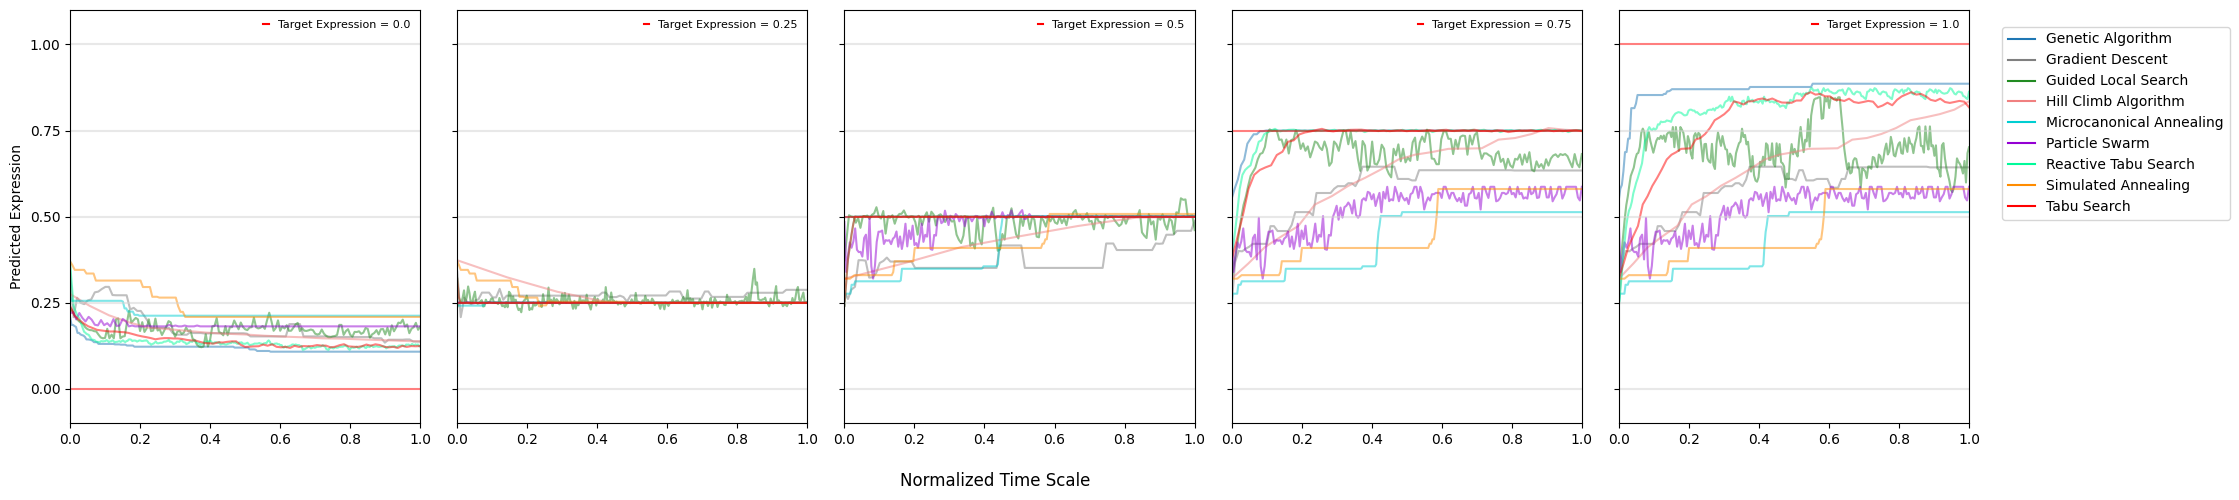

In [21]:

# -------------- Loading The Results --------------
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

# -------------- Get The Best Test For Each Optimizer And Target Expression --------------

df_exploded = results_df.explode('prediction_history').reset_index(drop=True)
df_exploded['prediction_history'] = df_exploded['prediction_history'].astype(float)

df_exploded['iteration'] = df_exploded.groupby(['optimizer', 'target_expression']).cumcount()
group_sizes = df_exploded.groupby(['optimizer', 'target_expression'])['prediction_history'].transform('count')
df_exploded['normalized_time_scale'] = df_exploded['iteration'] / (group_sizes - 1)

# -------------- Plot The Errors Over Time --------------

optimizer_names = df_exploded['optimizer'].unique()

target_expressions = df_exploded['target_expression'].unique()

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = df_exploded[
            (df_exploded['target_expression'] == target_expr) &
            (df_exploded['optimizer'] == optimizer)
        ]
        if not group.empty:
            ax.plot(
                group['normalized_time_scale'],
                group['prediction_history'],
                color=color_map[optimizer],
                alpha=0.5,
                label=optimizer
            )

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        ax.axhline(y=each, color=color, linestyle='-', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)
    # ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Normalized Time Scale")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


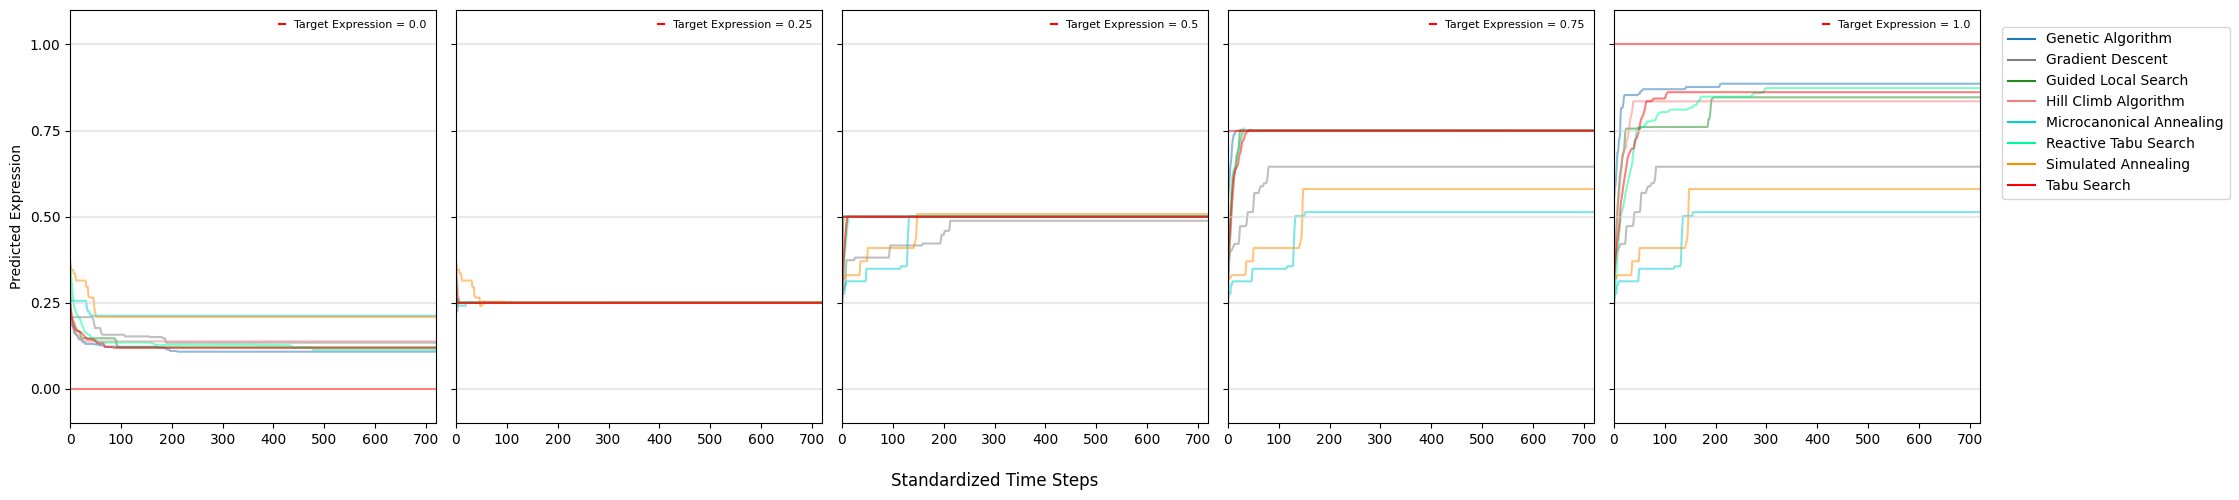

In [22]:

# -------------- Loading The Results --------------

results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)


# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# -------------- Plot The Errors Over Time --------------

optimizer_names = results_df['optimizer'].unique()

target_expressions = results_df['target_expression'].unique()

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        ax.axhline(y=each, color=color, linestyle='-', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Standardized Time Steps")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


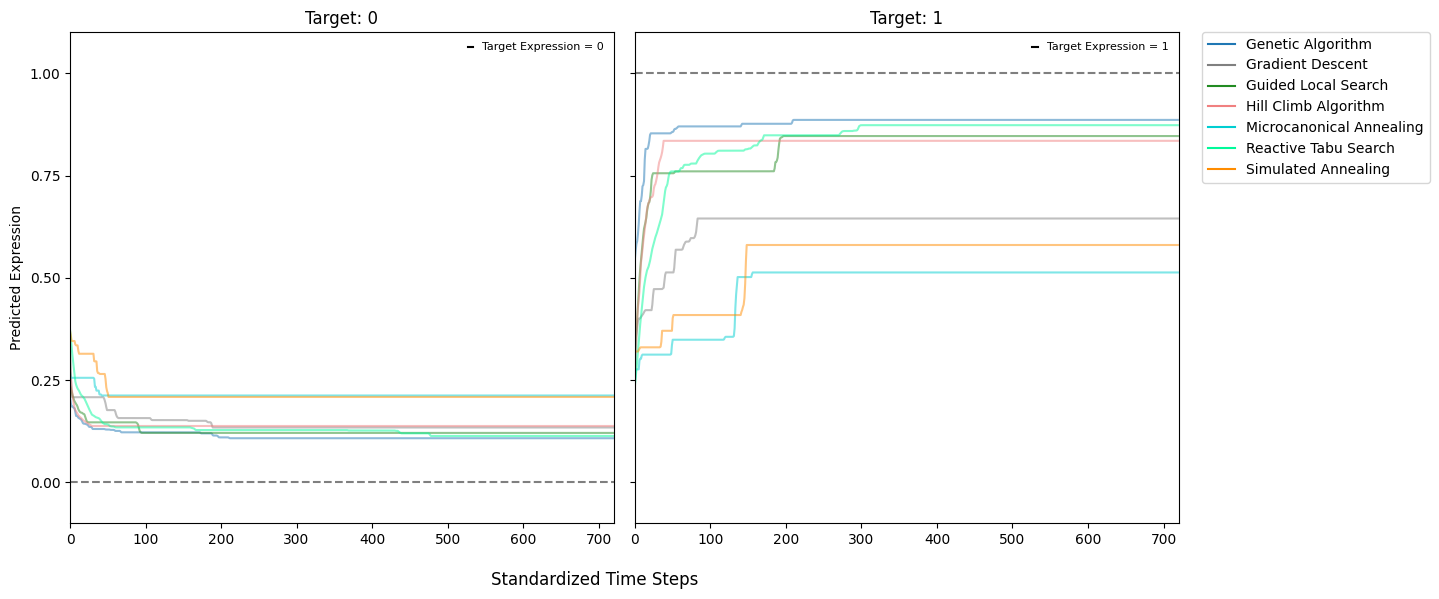

In [23]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']
results_df = results_df[results_df['optimizer'] != 'Tabu Search']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# -------------- Plot The Errors Over Time --------------

optimizer_names = results_df['optimizer'].unique()

target_expressions = [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='black', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)
    ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Standardized Time Steps")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


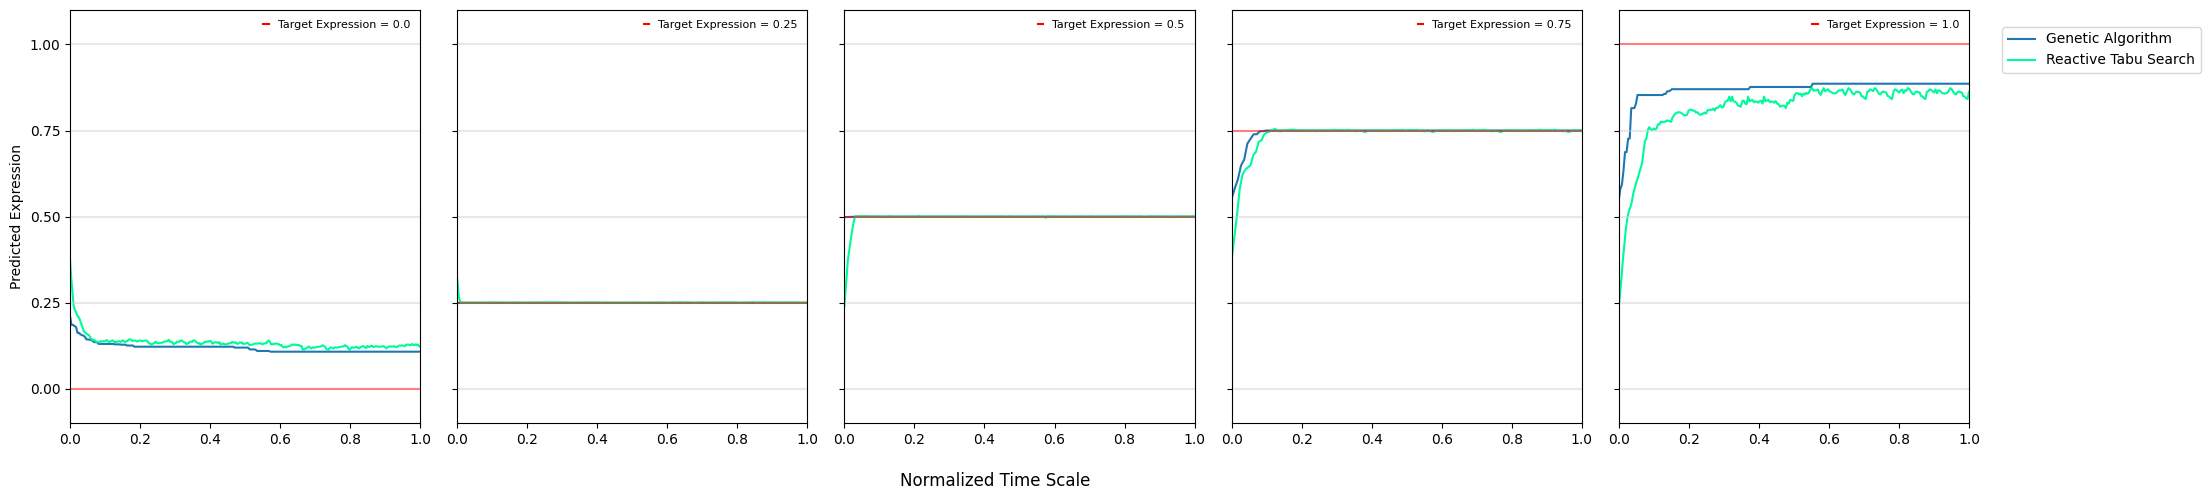

In [24]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

# -------------- Get The Best Test For Each Optimizer And Target Expression --------------

df_exploded = results_df.explode('prediction_history').reset_index(drop=True)
df_exploded['prediction_history'] = df_exploded['prediction_history'].astype(float)

df_exploded['iteration'] = df_exploded.groupby(['optimizer', 'target_expression']).cumcount()
group_sizes = df_exploded.groupby(['optimizer', 'target_expression'])['prediction_history'].transform('count')
df_exploded['normalized_time_scale'] = df_exploded['iteration'] / (group_sizes - 1)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = ['Genetic Algorithm', 'Reactive Tabu Search']
target_expressions = df_exploded['target_expression'].unique()

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = df_exploded[
            (df_exploded['target_expression'] == target_expr) &
            (df_exploded['optimizer'] == optimizer)
        ]
        if not group.empty:
            ax.plot(
                group['normalized_time_scale'],
                group['prediction_history'],
                color=color_map[optimizer],
                alpha=1,
                label=optimizer
            )

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        label = f'Target Expression = {each}' if each == target_expr else None
        ax.axhline(y=each, color=color, linestyle='-', alpha=0.5, label=label)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Normalized Time Scale")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


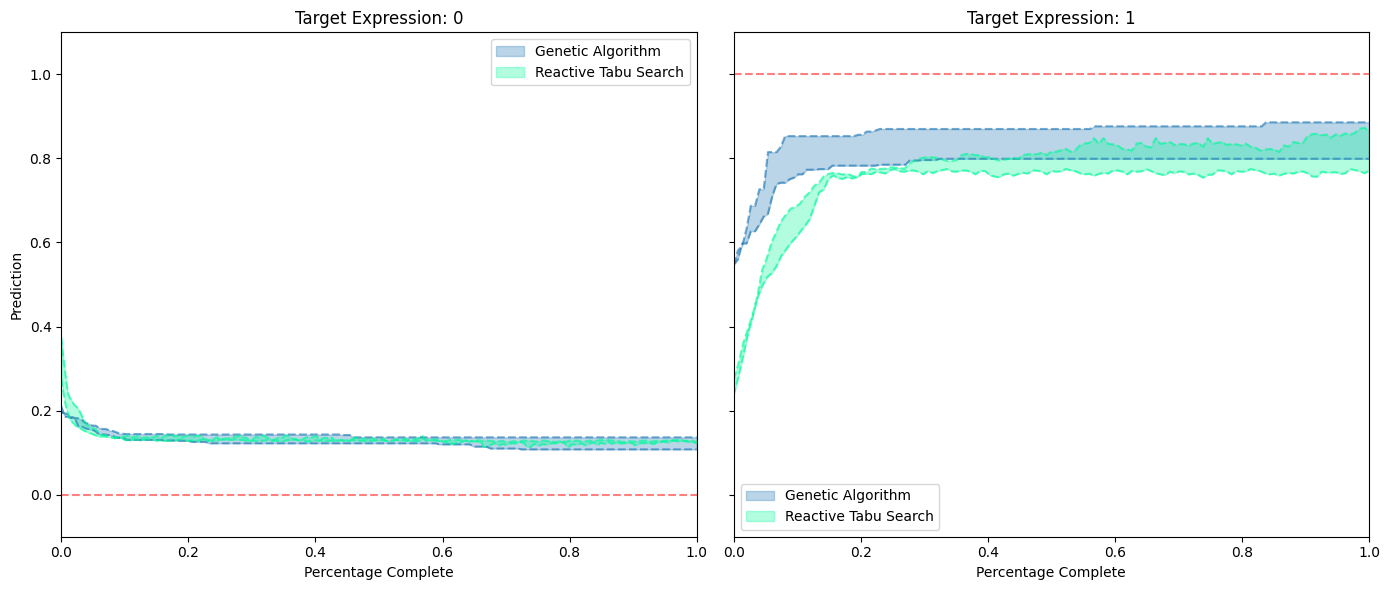

In [25]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Reactive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

# Compute percentage complete per optimizer/target_expression group
filtered_df['normalized_time_scale'] = filtered_df.groupby(
    ['optimizer', 'target_expression']
)['iteration'].transform(lambda x: x / x.max())

# Setup the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
target_expressions = [0, 1]

for idx, target in enumerate(target_expressions):
    ax = axes[idx]
    ax.set_title(f'Target Expression: {target}')
    ax.set_xlabel('Percentage Complete')
    if idx == 0:
        ax.set_ylabel('Prediction')

    for optimizer in optimizers_of_interest:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        if subset.empty:
            continue

        min_row = subset.loc[subset['error'].idxmin()]
        max_row = subset.loc[subset['error'].idxmax()]

        min_hist = np.array(min_row['prediction_history'])
        max_hist = np.array(max_row['prediction_history'])

        # Ensure both histories are the same length
        min_len = min(len(min_hist), len(max_hist))
        min_hist = min_hist[:min_len]
        max_hist = max_hist[:min_len]

        # Create normalized_time_scale x-axis for the run
        x = np.linspace(0, 1, min_len)

        ax.fill_between(x, min_hist, max_hist, alpha=0.3, label=f'{optimizer}', color=color_map[optimizer])
        ax.plot(x, min_hist, linestyle='--', alpha=0.6, color=color_map[optimizer])
        ax.plot(x, max_hist, linestyle='--', alpha=0.6, color=color_map[optimizer])

    ax.axhline(y=target, color='red', linestyle='--', alpha=0.5)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)

    ax.legend()

plt.tight_layout()
plt.show()


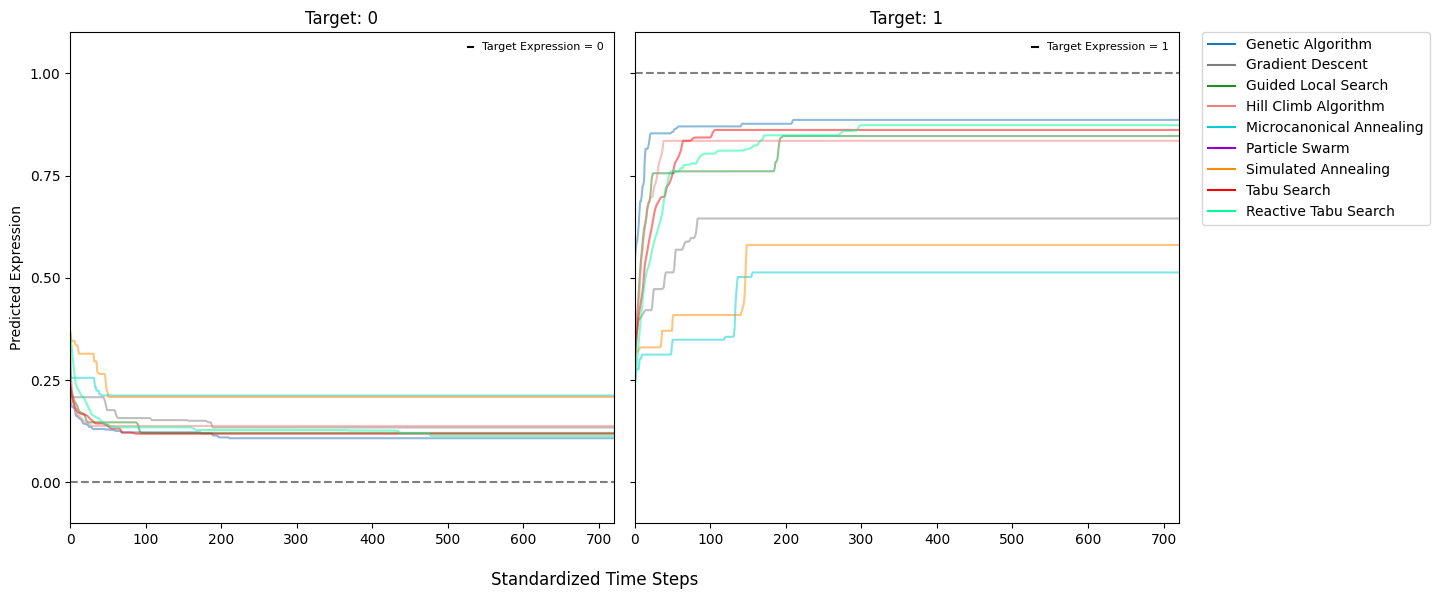

In [26]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()
target_expressions = [0, 1]

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='black', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)
    ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Standardized Time Steps")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
# plt.savefig('Data/Figure 6b.png', dpi=300, bbox_inches='tight')
plt.show()


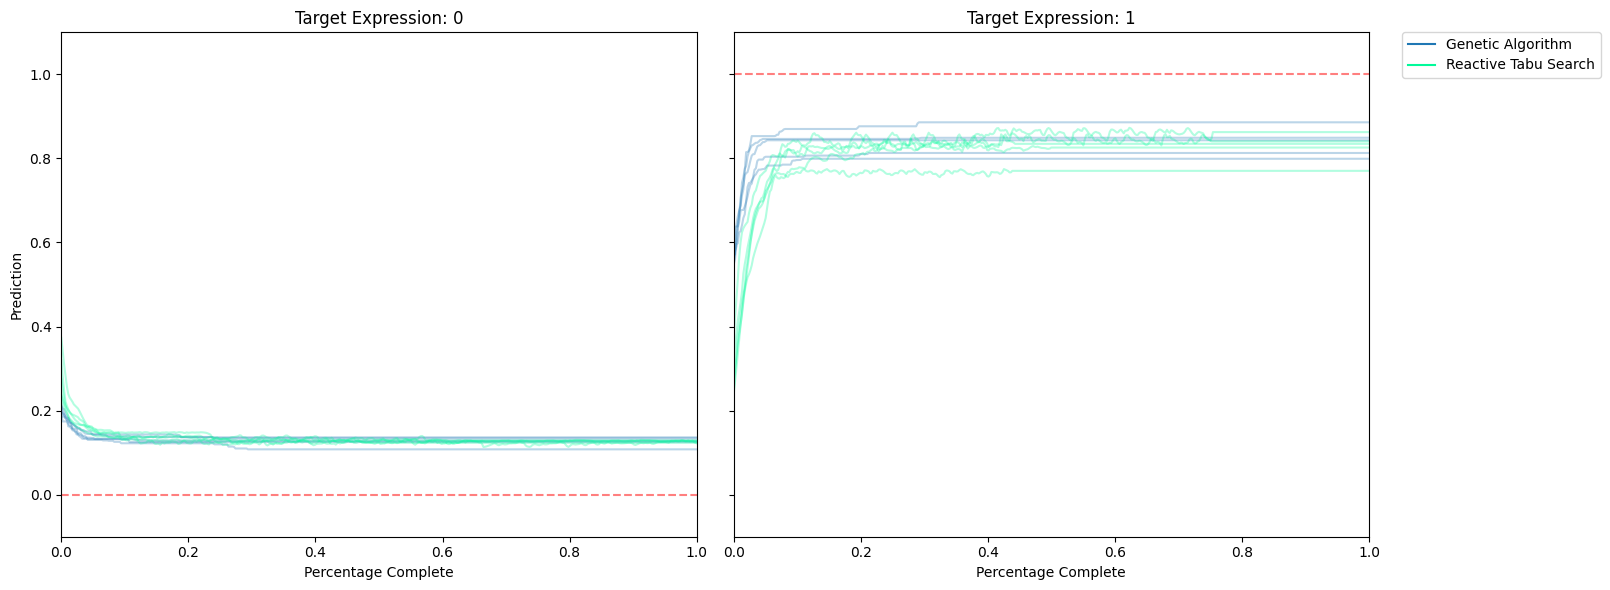

In [27]:
# Load and parse list-like columns
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Reactive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

filtered_df = dynamic_standardize_prediction_history(filtered_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = filtered_df['prediction_history'].apply(len).max()

filtered_df['prediction_history'] = filtered_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# Setup the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
target_expressions = [0, 1]

for idx, target in enumerate(target_expressions):
    ax = axes[idx]
    ax.set_title(f'Target Expression: {target}')
    ax.set_xlabel('Percentage Complete')
    if idx == 0:
        ax.set_ylabel('Prediction')

    for optimizer in optimizers_of_interest:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        for _, row in subset.iterrows():
            prediction_history = np.array(row['prediction_history'])
            x = np.linspace(0, 1, len(prediction_history))
            ax.plot(x, prediction_history, color=color_map[optimizer], alpha=0.3)
    
    ax.axhline(y=target, color='red', linestyle='--', alpha=0.5)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)

handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizers_of_interest]
fig.legend(
    handles=handles,
    labels=optimizers_of_interest,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


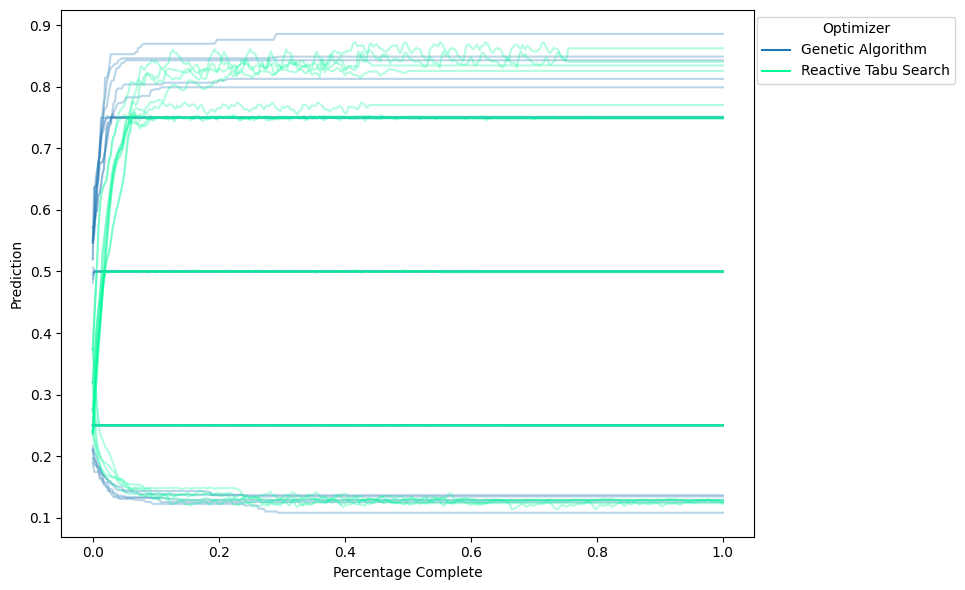

In [28]:
# Load and parse list-like columns
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Reactive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

filtered_df = dynamic_standardize_prediction_history(filtered_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = filtered_df['prediction_history'].apply(len).max()

filtered_df['prediction_history'] = filtered_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

target_expressions = sorted(results_df['target_expression'].unique())
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all runs
for optimizer in optimizers_of_interest:
    for target in target_expressions:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        for _, row in subset.iterrows():
            prediction_history = np.array(row['prediction_history'])
            x = np.linspace(0, 1, len(prediction_history))  # percentage complete
            ax.plot(x, prediction_history, color=color_map.get(optimizer, 'gray'), alpha=0.3)

# Create custom legend
handles = [plt.Line2D([], [], color=color_map[optimizer], label=str(optimizer)) for optimizer in optimizers_of_interest]

# put legend outside the plot
ax.legend(handles=handles, title="Optimizer", loc='upper right', bbox_to_anchor=(1.3, 1))

ax.set_xlabel("Percentage Complete")
ax.set_ylabel("Prediction")

plt.tight_layout()
plt.show()


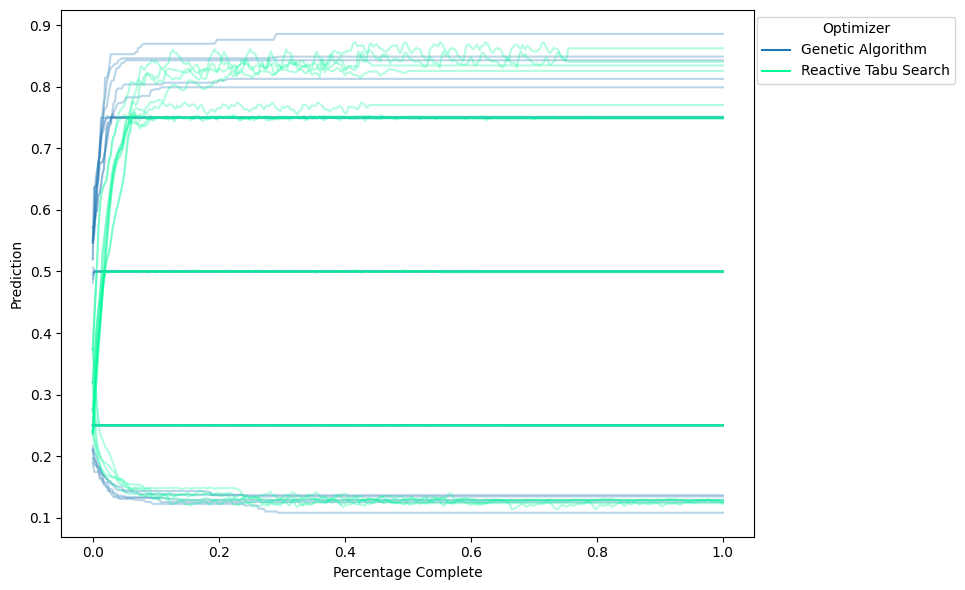

In [29]:
# Load and parse list-like columns
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Reactive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

filtered_df = dynamic_standardize_prediction_history(filtered_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = filtered_df['prediction_history'].apply(len).max()

filtered_df['prediction_history'] = filtered_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

target_expressions = sorted(results_df['target_expression'].unique())

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all runs
for optimizer in optimizers_of_interest:
    for target in target_expressions:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        for _, row in subset.iterrows():
            prediction_history = np.array(row['prediction_history'])
            x = np.linspace(0, 1, len(prediction_history))  # percentage complete
            ax.plot(x, prediction_history, color=color_map.get(optimizer, 'gray'), alpha=0.3)

# Create custom legend
handles = [plt.Line2D([], [], color=color_map[optimizer], label=str(optimizer)) for optimizer in optimizers_of_interest]

# put legend outside the plot
ax.legend(handles=handles, title="Optimizer", loc='upper right', bbox_to_anchor=(1.3, 1))

ax.set_xlabel("Percentage Complete")
ax.set_ylabel("Prediction")

plt.tight_layout()
plt.show()


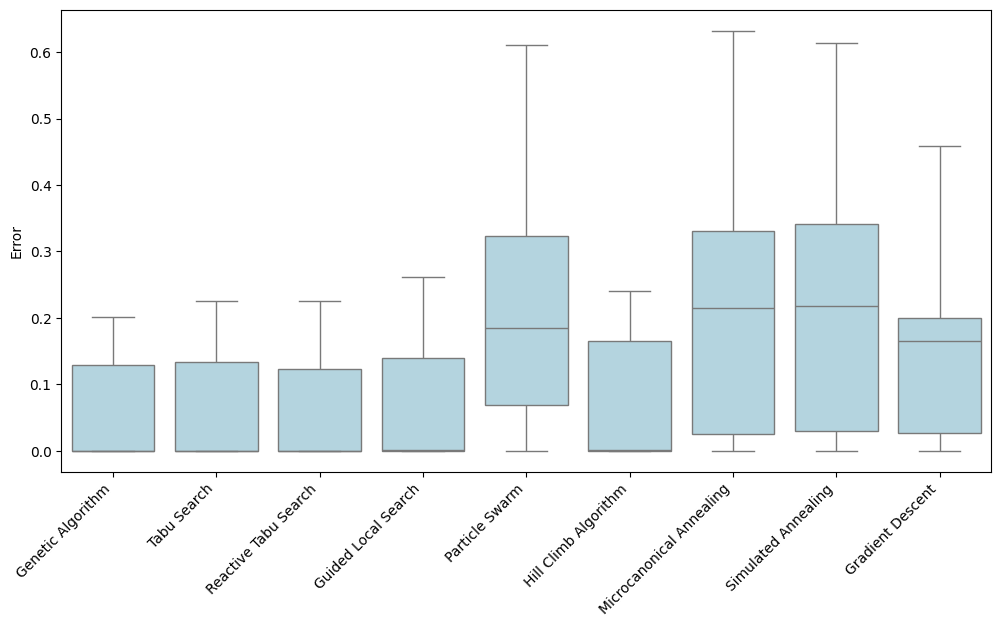

In [30]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df = results_df.sort_values(by='error')

# Plotting the error for each optimizer
plt.figure(figsize=(12, 6))
sns.boxplot(x='optimizer', y='error', data=results_df, color='lightblue',
            order=results_df['optimizer'].unique())
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error')
plt.show()


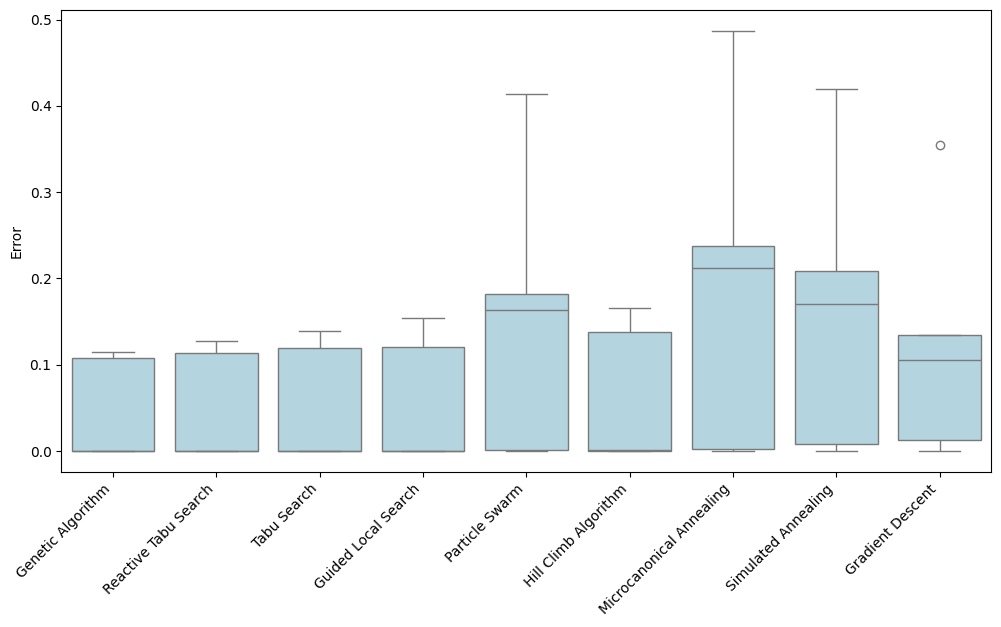

In [31]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

# Get the best test for each optimizer and target expression (without)
grouped = results_df.groupby(['optimizer', 'target_expression'])
best_rows = []
for (optimizer, target), group in grouped:
    best_error_idx = group['error'].idxmin()
    best_row = group.loc[best_error_idx]

    best_rows.append({
        'optimizer': optimizer,
        'target_expression': target,
        'prediction': best_row['prediction'],
        'error': best_row['error'],
    })

results_df =  pd.DataFrame(best_rows)
results_df = results_df.sort_values(by='error')

# Plotting the error for each optimizer
plt.figure(figsize=(12, 6))
sns.boxplot(x='optimizer', y='error', data=results_df, color='lightblue',
            order=results_df['optimizer'].unique())
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error')
plt.show()


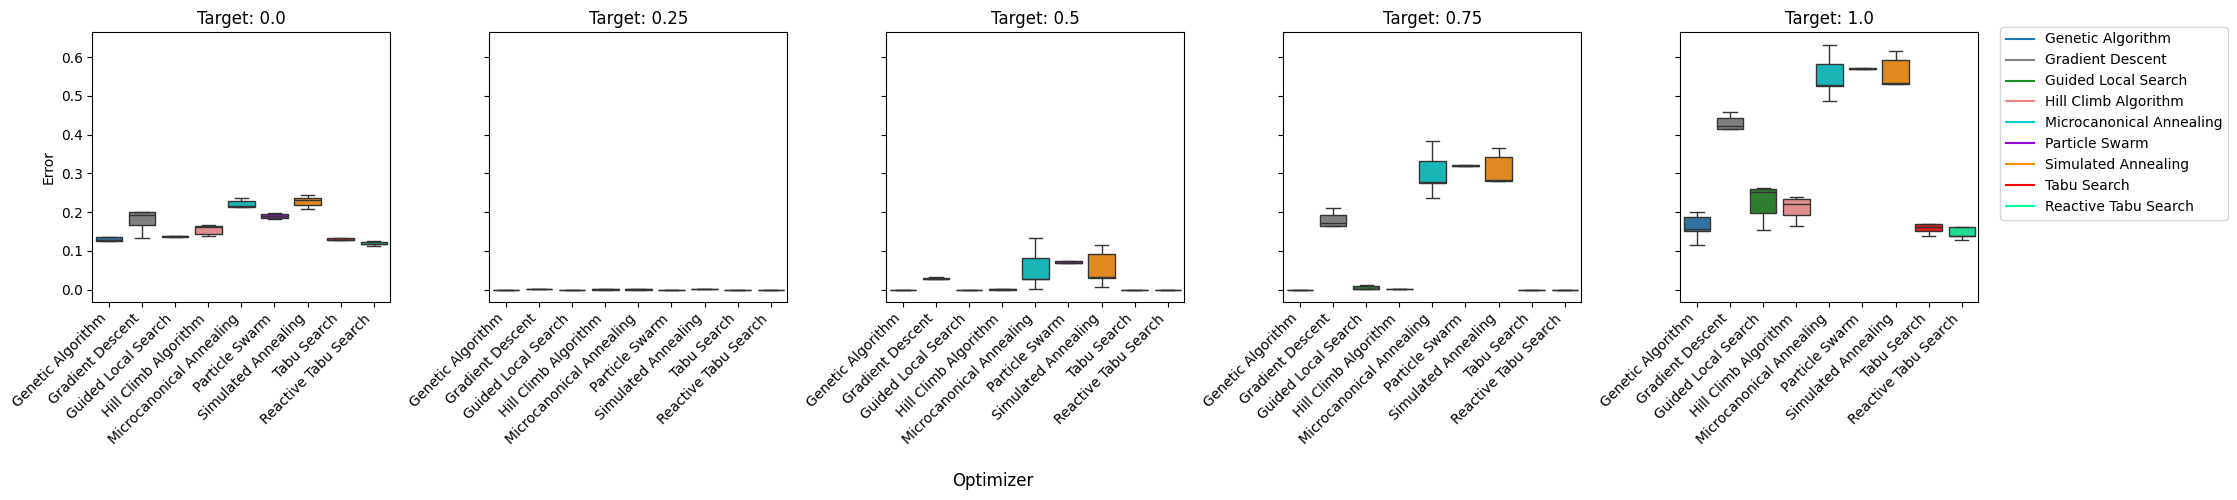

In [32]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='error',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Error')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

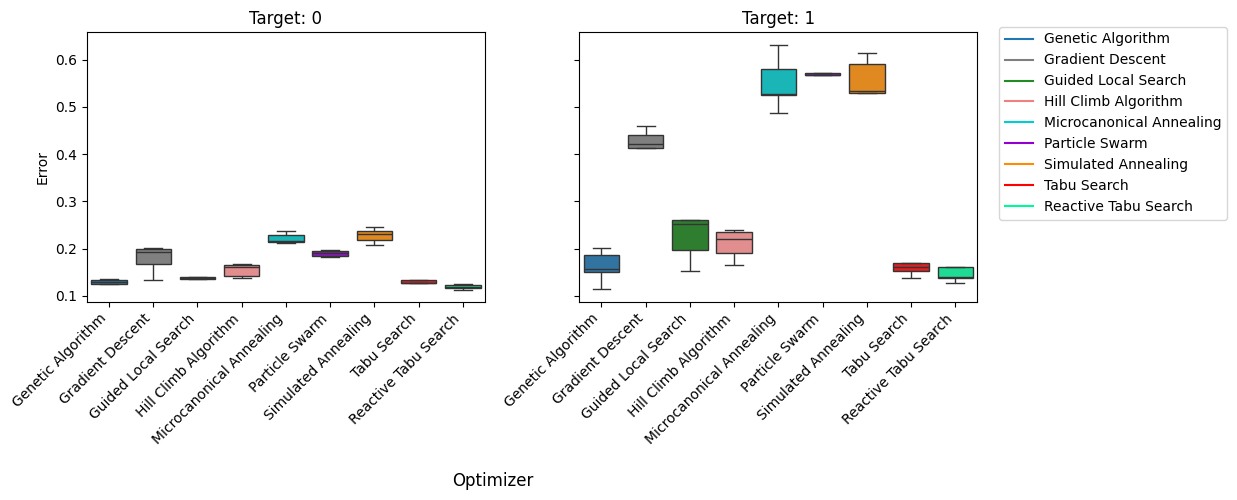

In [33]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='error',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Error')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

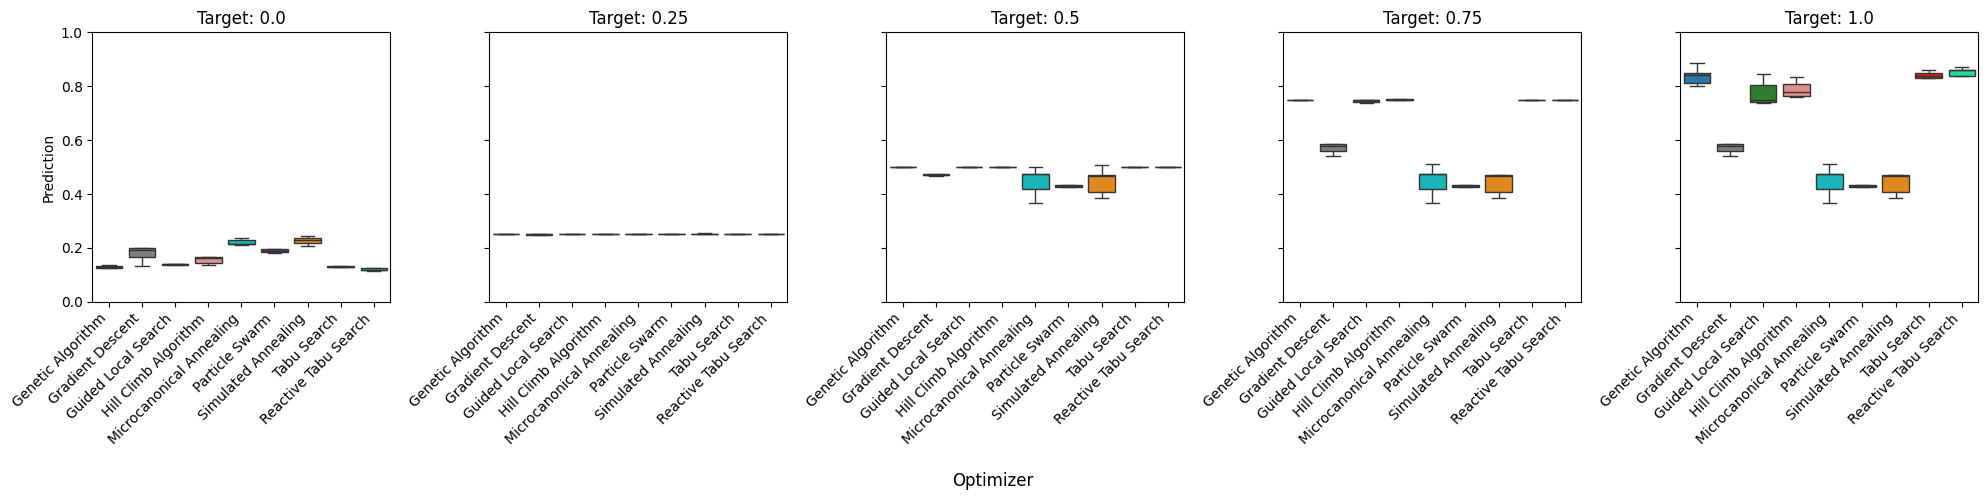

In [34]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prediction')
    axes[i].set_ylim(0, 1)
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

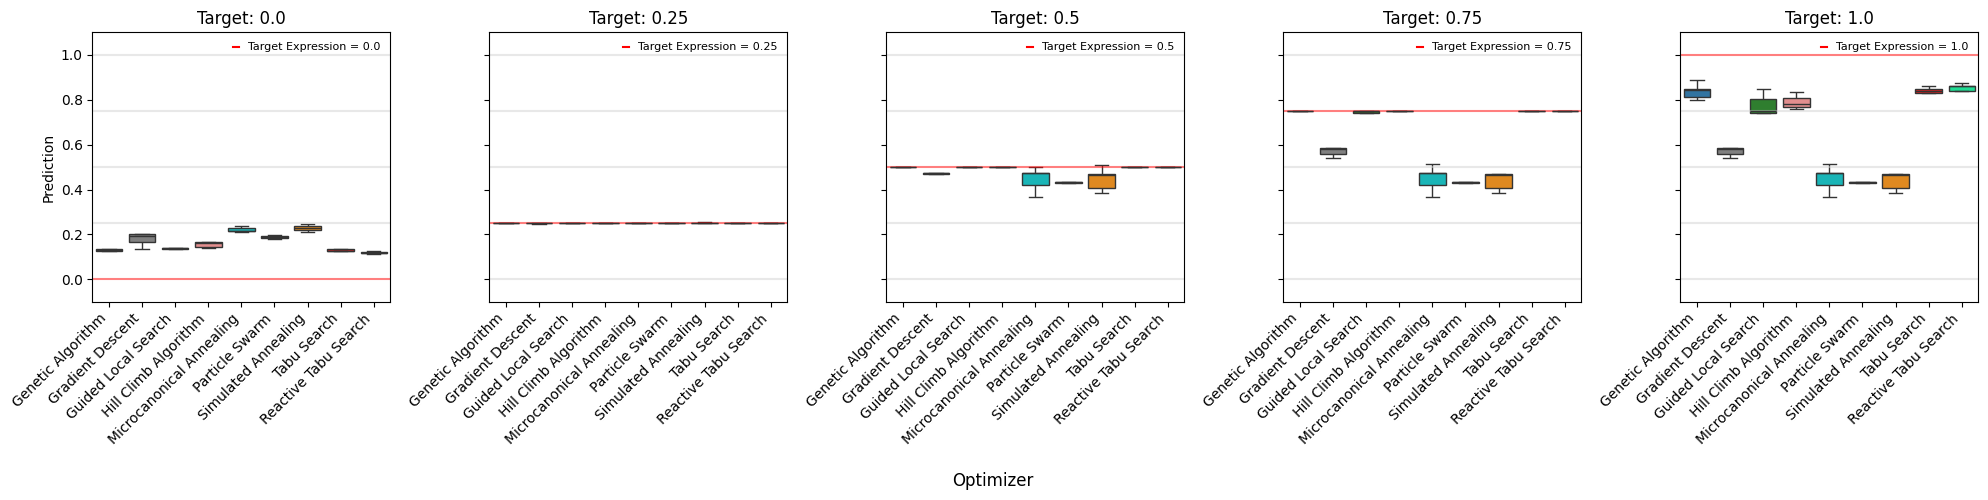

In [35]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prediction')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        label = f'Target Expression = {each}' if each == target_expr else None
        axes[i].axhline(y=each, color=color, linestyle='-', alpha=0.5, label=label)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    axes[i].legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    axes[i].set_ylim(-0.1, 1.1)
    

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
# fig.legend(
#     handles=handles,
#     labels=labels,
#     loc='upper left',
#     bbox_to_anchor=(1, 0.95),
#     bbox_transform=fig.transFigure
# )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

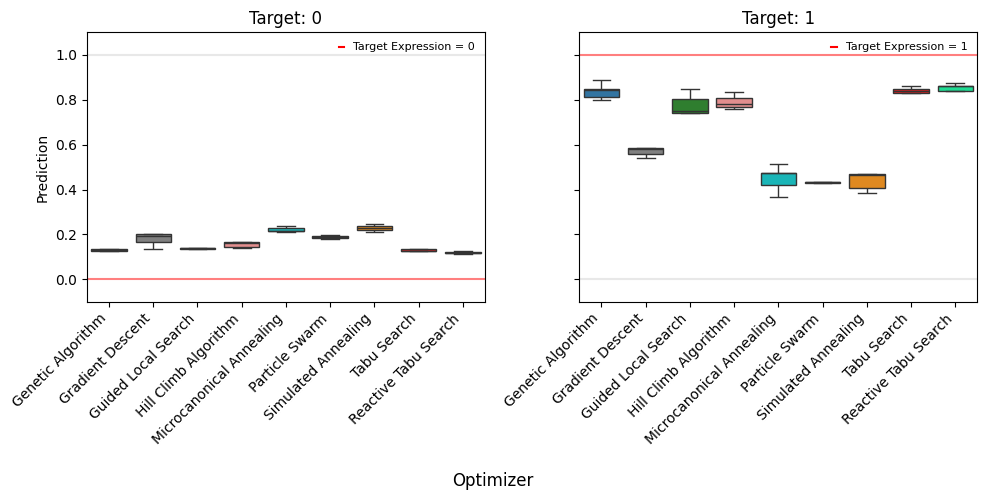

In [36]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prediction')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        label = f'Target Expression = {each}' if each == target_expr else None
        axes[i].axhline(y=each, color=color, linestyle='-', alpha=0.5, label=label)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    axes[i].legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    axes[i].set_ylim(-0.1, 1.1)
    

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
# fig.legend(
#     handles=handles,
#     labels=labels,
#     loc='upper left',
#     bbox_to_anchor=(1, 0.95),
#     bbox_transform=fig.transFigure
# )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### Hamming Distance
---

In [37]:
def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))


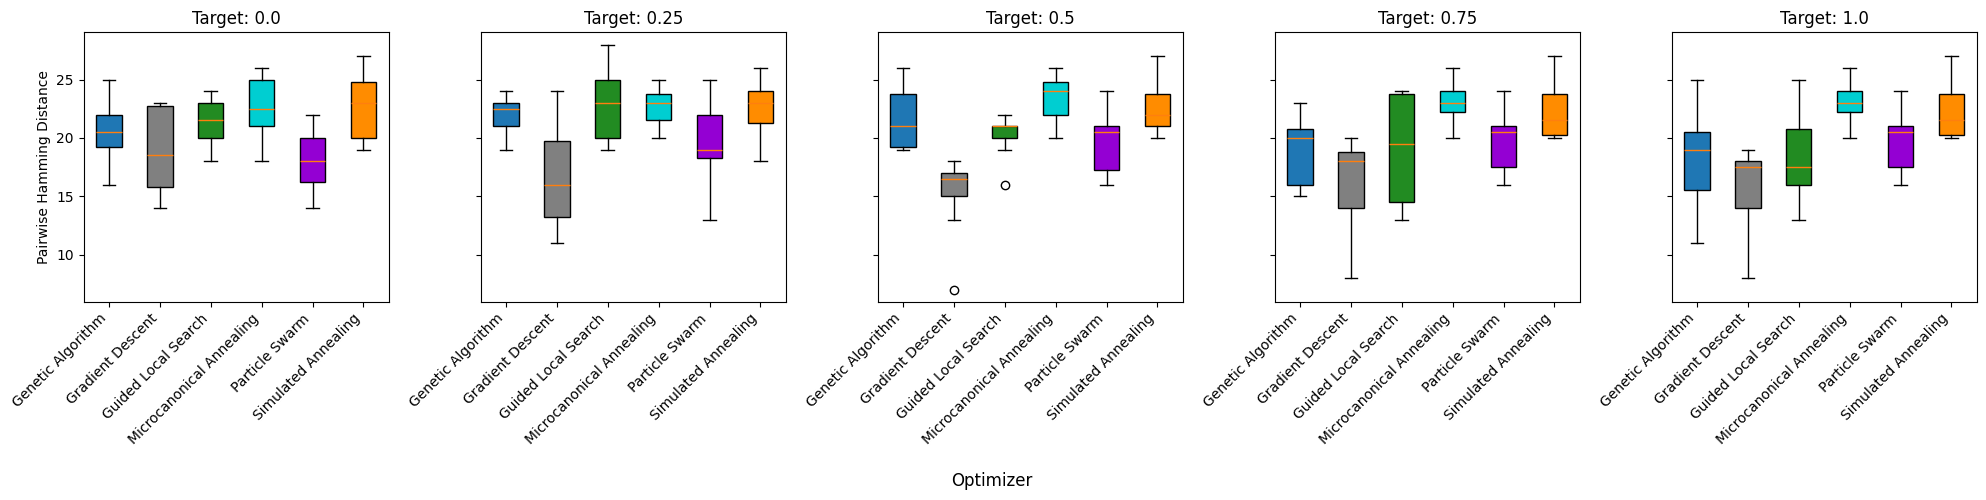

In [38]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

# get optimizer names, but exclude deterministic optimizers
optimizer_names = results_df['optimizer'].unique()
optimizer_names = [name for name in optimizer_names if name not in ['Hill Climb Algorithm', 'Tabu Search', 'Reactive Tabu Search']]

# Plot the boxplot distribution of pairwise hamming distances for every optimizer and target expression combination
for i, target in enumerate(target_expressions):
    ax = axes[i]
    target_df = results_df[results_df['target_expression'] == target]
    
    data_to_plot = []
    
    for opt in optimizer_names:
        opt_df = target_df[target_df['optimizer'] == opt]
        sequences = opt_df['sequence'].values
        hamming_distances = []
        
        for seq1, seq2 in combinations(sequences, 2):
            hamming_distances.append(hamming_distance(seq1, seq2))
        
        data_to_plot.append(hamming_distances)
    
    # Boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Color the boxes
    for patch, opt in zip(bp['boxes'], optimizer_names):
        patch.set_facecolor(color_map[opt])
    
    ax.set_title(f'Target: {target}')
    ax.set_xlabel('')
    ax.set_xticks(range(1, len(optimizer_names) + 1))
    ax.set_xticklabels(optimizer_names, rotation=45, ha='right')

    if i == 0:
        ax.set_ylabel('Pairwise Hamming Distance')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


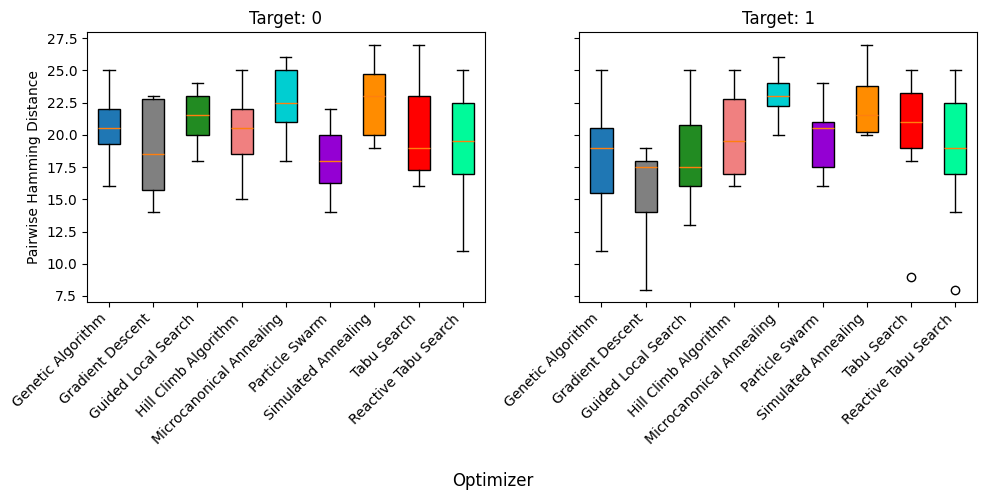

In [39]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot the boxplot distribution of pairwise hamming distances for every optimizer and target expression combination
for i, target in enumerate(target_expressions):
    ax = axes[i]
    target_df = results_df[results_df['target_expression'] == target]
    
    data_to_plot = []
    
    for opt in optimizer_names:
        opt_df = target_df[target_df['optimizer'] == opt]
        sequences = opt_df['sequence'].values
        hamming_distances = []
        
        for seq1, seq2 in combinations(sequences, 2):
            hamming_distances.append(hamming_distance(seq1, seq2))
        
        data_to_plot.append(hamming_distances)
    
    # Boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Color the boxes
    for patch, opt in zip(bp['boxes'], optimizer_names):
        patch.set_facecolor(color_map[opt])
    
    ax.set_title(f'Target: {target}')
    ax.set_xlabel('')
    ax.set_xticks(range(1, len(optimizer_names) + 1))
    ax.set_xticklabels(optimizer_names, rotation=45, ha='right')

    if i == 0:
        ax.set_ylabel('Pairwise Hamming Distance')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


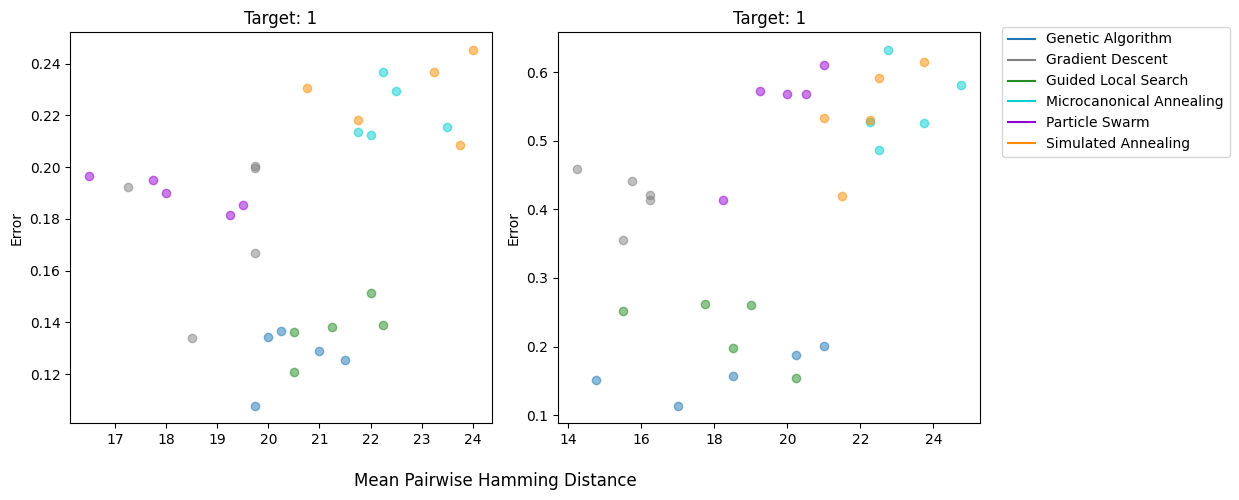

In [40]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

# get optimizer names, but exclude deterministic optimizers
optimizer_names = results_df['optimizer'].unique()
optimizer_names = [name for name in optimizer_names if name not in ['Hill Climb Algorithm', 'Tabu Search', 'Reactive Tabu Search']]

for i, target in enumerate(target_expressions):
    ax = axes[i]
    target_df = results_df[results_df['target_expression'] == target]
    
    for opt in optimizer_names:
        opt_df = target_df[target_df['optimizer'] == opt]
        sequences = opt_df['sequence'].values
        errors = opt_df['error'].values
        hamming_distances = {}
        
        for i, seq1 in enumerate(sequences):
            for seq2 in sequences:
                if seq1 != seq2:
                    dist = hamming_distance(seq1, seq2)
                    if seq1 not in hamming_distances:
                        hamming_distances[seq1] = []
                    hamming_distances[seq1].append(dist)
            
            mean_distance = np.mean(hamming_distances[seq1])

            # plot a scatter point for each sequence's mean hamming distance and error
            ax.scatter(mean_distance, errors[i], color=color_map[opt], alpha=0.5)

    ax.set_title(f'Target: {target_expr}')
    ax.set_ylabel('Error')
            
    if i == 0:
        ax.set_ylabel('Pairwise Hamming Distance')

fig.supxlabel("Mean Pairwise Hamming Distance")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [41]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

results_df = results_df[results_df['target_expression'] == 0]

optimizer_names = ['Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm', 'Gradient Descent']

for optimizer1 in optimizer_names:
    for optimizer2 in optimizer_names:
        if optimizer1 == optimizer2:
            continue
        seq1 = results_df[results_df['optimizer'] == optimizer1]['sequence'].values[0]
        seq2 = results_df[results_df['optimizer'] == optimizer2]['sequence'].values[0]
        distance = hamming_distance(seq1, seq2)
        print(f'{optimizer1} | {optimizer2} = {distance}')
    print()

Tabu Search | Guided Local Search = 19
Tabu Search | Hill Climb Algorithm = 16
Tabu Search | Gradient Descent = 19

Guided Local Search | Tabu Search = 19
Guided Local Search | Hill Climb Algorithm = 21
Guided Local Search | Gradient Descent = 16

Hill Climb Algorithm | Tabu Search = 16
Hill Climb Algorithm | Guided Local Search = 21
Hill Climb Algorithm | Gradient Descent = 18

Gradient Descent | Tabu Search = 19
Gradient Descent | Guided Local Search = 16
Gradient Descent | Hill Climb Algorithm = 18



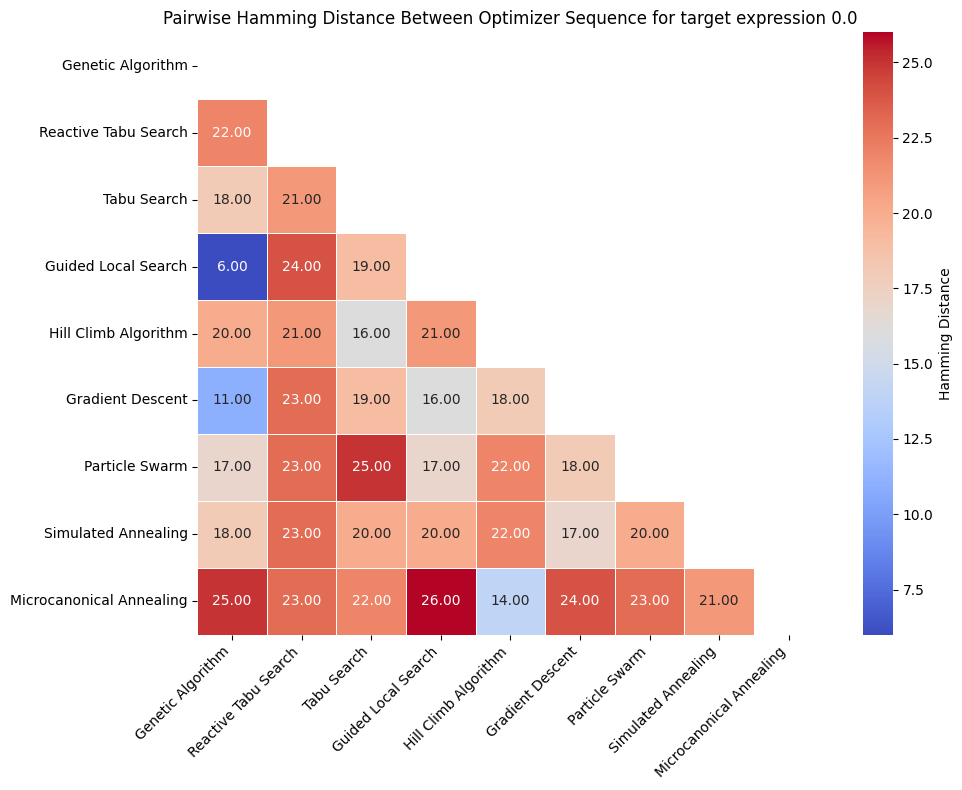

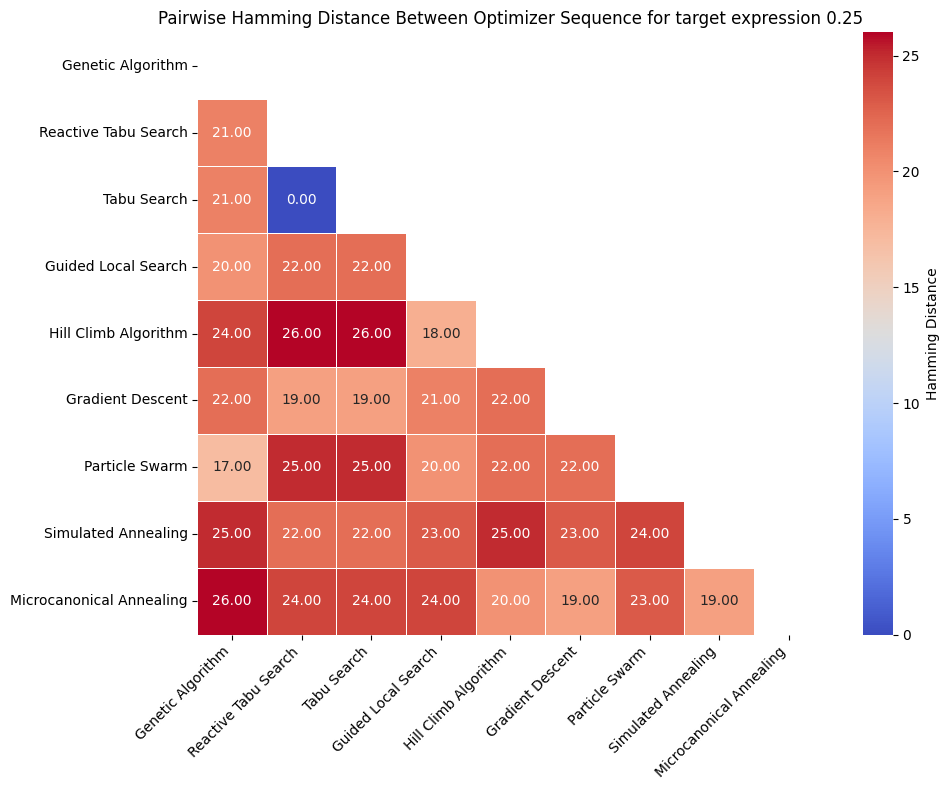

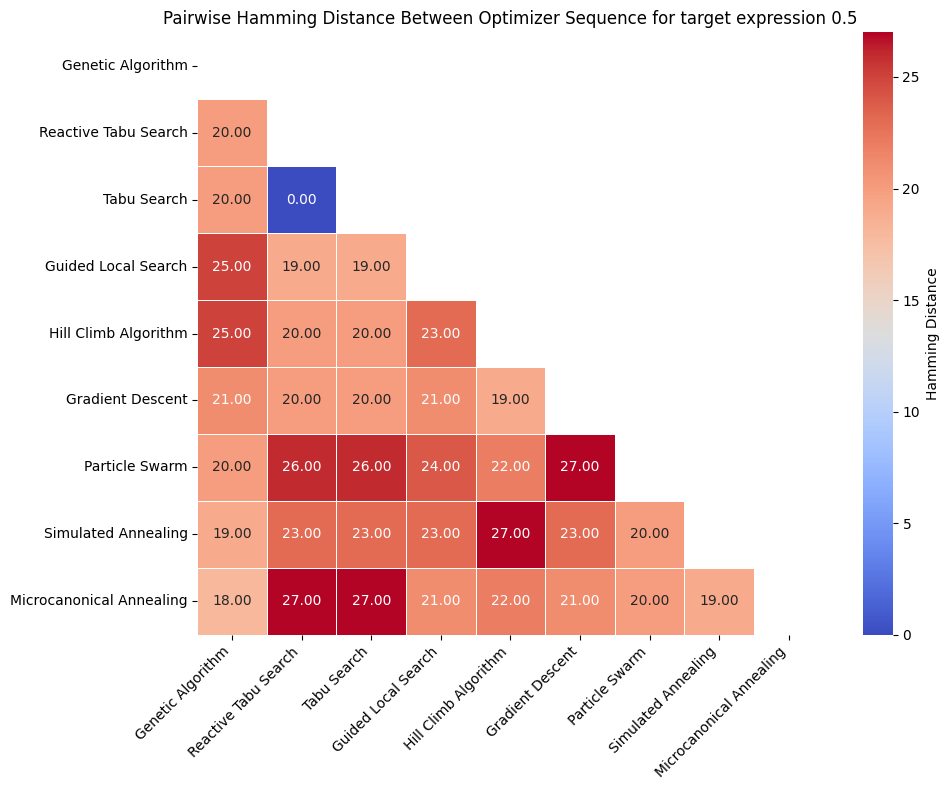

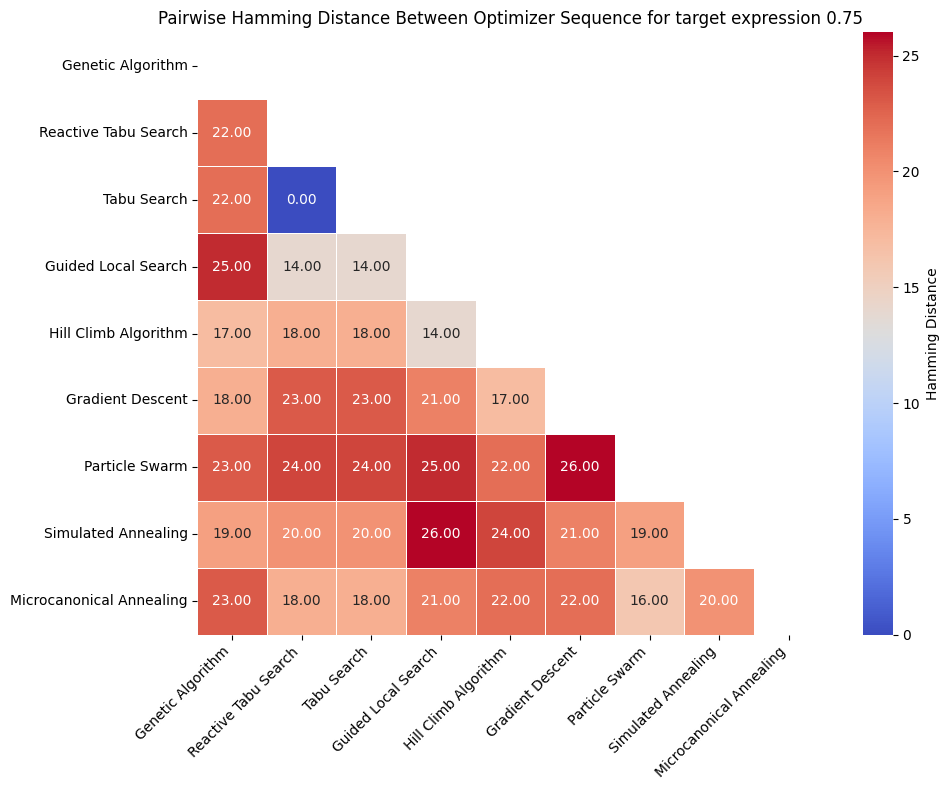

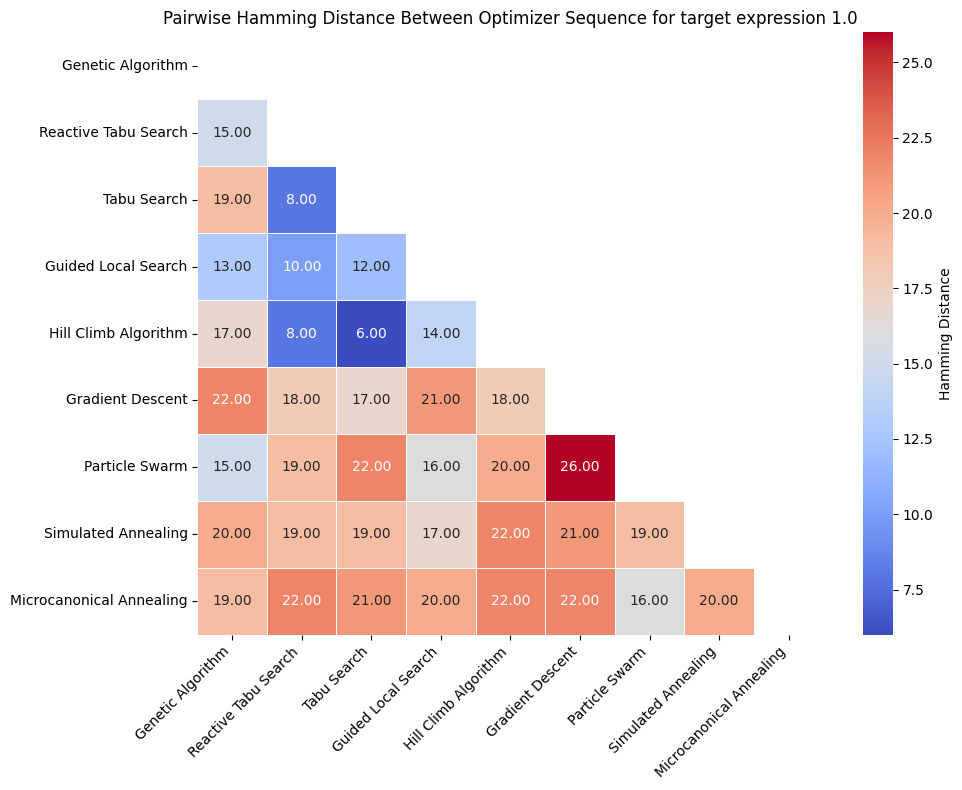

In [42]:
# Load and preprocess the data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

global_error_means = results_df.groupby('optimizer')['error'].mean()
global_sorted_optimizers = global_error_means.sort_values().index.tolist()

target_expressions = results_df['target_expression'].unique()
hamming_dfs = {}

for target in target_expressions:
    target_df = results_df[results_df['target_expression'] == target]

    error_means = target_df.groupby('optimizer')['error'].mean()
    sorted_optimizers = error_means.sort_values().index.tolist()

    hamming_matrix = pd.DataFrame(index=global_sorted_optimizers, columns=global_sorted_optimizers, dtype=float)

    for opt1, opt2 in product(global_sorted_optimizers, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
            seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
            distance = hamming_distance(seq1, seq2)
            hamming_matrix.loc[opt1, opt2] = distance

    hamming_dfs[target] = hamming_matrix

for target, hamming_df in hamming_dfs.items():

    mask = np.triu(np.ones_like(hamming_df, dtype=bool))

    plt.figure(figsize=(10, 8))

    sns.heatmap(
        hamming_df,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Hamming Distance'}
    )

    plt.title(f'Pairwise Hamming Distance Between Optimizer Sequence for target expression {target}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [43]:
# Load and preprocess the data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

# Get unique target expressions
target_expressions = results_df['target_expression'].unique()

# List of optimizers
optimizer_names = ['Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm', 'Gradient Descent']

# Dictionary to store DataFrames for each target_expression
hamming_dfs = {}

for target in target_expressions:
    target_df = results_df[results_df['target_expression'] == target]

    # Initialize a DataFrame with optimizers as both rows and columns
    hamming_matrix = pd.DataFrame(index=optimizer_names, columns=optimizer_names, dtype=float)

    for opt1, opt2 in product(optimizer_names, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
            seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
            distance = hamming_distance(seq1, seq2)
            hamming_matrix.loc[opt1, opt2] = distance

    # Sort the matrix by the sum of distances in rows
    hamming_matrix = hamming_matrix.loc[hamming_matrix.sum(axis=1).sort_values().index]
    hamming_matrix = hamming_matrix[hamming_matrix.sum().sort_values().index]
    hamming_dfs[target] = hamming_matrix

hamming_dfs[0]


Gradient Descent  Tabu Search  Hill Climb Algorithm  \
Gradient Descent                   0.0         19.0                  18.0   
Tabu Search                       19.0          0.0                  16.0   
Hill Climb Algorithm              18.0         16.0                   0.0   
Guided Local Search               16.0         19.0                  21.0   

                      Guided Local Search  
Gradient Descent                     16.0  
Tabu Search                          19.0  
Hill Climb Algorithm                 21.0  
Guided Local Search                   0.0

### Tables
---

In [44]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

results_df = best_tests(results_df)

min_error_preds = results_df.drop_duplicates(subset=['optimizer', 'target_expression'], keep='first')

pivot_df = min_error_preds.pivot(
    index='optimizer',
    columns='target_expression',
    values='prediction'
)

pivot_df.columns = [f'prediction (target_expression={col})' for col in pivot_df.columns]
pivot_df = pivot_df.sort_values(by=pivot_df.columns[-1], ascending=False)
pivot_df = pivot_df.reset_index()

pivot_df


optimizer  prediction (target_expression=0.0)  \
0         Genetic Algorithm                            0.107874   
1      Reactive Tabu Search                            0.113416   
2               Tabu Search                            0.118780   
3       Guided Local Search                            0.120862   
4      Hill Climb Algorithm                            0.137827   
5          Gradient Descent                            0.134133   
6            Particle Swarm                            0.181424   
7       Simulated Annealing                            0.208723   
8  Microcanonical Annealing                            0.212349   

   prediction (target_expression=0.25)  prediction (target_expression=0.5)  \
0                             0.249999                            0.500000   
1                             0.250000                            0.500001   
2                             0.250000                            0.500001   
3                             0.250002                            0.499996   
4                             0.250009                            0.500015   
5                             0.249784                            0.487831   
6                             0.250005                            0.499646   
7                             0.250161                            0.507794   
8                             0.250067                            0.501824   

   prediction (target_expression=0.75)  prediction (target_expression=1.0)  
0                             0.749995                            0.885947  
1                             0.750004                            0.873045  
2                             0.750004                            0.861419  
3                             0.750144                            0.846510  
4                             0.749663                            0.834812  
5                             0.644957                            0.644957  
6                             0.586647                            0.586647  
7                             0.580200                            0.580200  
8                             0.513064                            0.513064

In [45]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

results_df = best_tests(results_df)

min_error_preds = results_df.drop_duplicates(subset=['optimizer', 'target_expression'], keep='first')

pivot_df = min_error_preds.pivot(
    index='optimizer',
    columns='target_expression',
    values='error'
)

pivot_df.columns = [f'error (target_expression={col})' for col in pivot_df.columns]
pivot_df = pivot_df.sort_values(by=pivot_df.columns[-1], ascending=True)
pivot_df = pivot_df.reset_index()
pivot_df = pivot_df.round(6)

pivot_df


optimizer  error (target_expression=0.0)  \
0         Genetic Algorithm                       0.107874   
1      Reactive Tabu Search                       0.113416   
2               Tabu Search                       0.118780   
3       Guided Local Search                       0.120862   
4      Hill Climb Algorithm                       0.137827   
5          Gradient Descent                       0.134133   
6            Particle Swarm                       0.181424   
7       Simulated Annealing                       0.208723   
8  Microcanonical Annealing                       0.212349   

   error (target_expression=0.25)  error (target_expression=0.5)  \
0                        0.000001                       0.000000   
1                        0.000000                       0.000001   
2                        0.000000                       0.000001   
3                        0.000002                       0.000004   
4                        0.000009                       0.000015   
5                        0.000216                       0.012169   
6                        0.000005                       0.000354   
7                        0.000161                       0.007794   
8                        0.000067                       0.001824   

   error (target_expression=0.75)  error (target_expression=1.0)  
0                        0.000005                       0.114053  
1                        0.000004                       0.126955  
2                        0.000004                       0.138581  
3                        0.000144                       0.153490  
4                        0.000337                       0.165188  
5                        0.105043                       0.355043  
6                        0.163353                       0.413353  
7                        0.169800                       0.419800  
8                        0.236936                       0.486936

In [46]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)[['optimizer', 'target_expression', 'prediction', 'error']]

results_df.head(None)

optimizer  target_expression  prediction         error
0          Genetic Algorithm               0.00    0.107874  1.078736e-01
1          Genetic Algorithm               0.25    0.249999  5.960464e-07
2          Genetic Algorithm               0.50    0.500000  4.172325e-07
3          Genetic Algorithm               0.75    0.749995  5.006790e-06
4          Genetic Algorithm               1.00    0.885947  1.140527e-01
5           Gradient Descent               0.00    0.134133  1.341330e-01
6           Gradient Descent               0.25    0.249784  2.162904e-04
7           Gradient Descent               0.50    0.487831  1.216853e-02
8           Gradient Descent               0.75    0.644957  1.050426e-01
9           Gradient Descent               1.00    0.644957  3.550426e-01
10       Guided Local Search               0.00    0.120862  1.208617e-01
11       Guided Local Search               0.25    0.250002  1.579523e-06
12       Guided Local Search               0.50    0.499996  3.695488e-06
13       Guided Local Search               0.75    0.750144  1.436472e-04
14       Guided Local Search               1.00    0.846510  1.534902e-01
15      Hill Climb Algorithm               0.00    0.137827  1.378267e-01
16      Hill Climb Algorithm               0.25    0.250009  8.672476e-06
17      Hill Climb Algorithm               0.50    0.500015  1.549721e-05
18      Hill Climb Algorithm               0.75    0.749663  3.370047e-04
19      Hill Climb Algorithm               1.00    0.834812  1.651882e-01
20  Microcanonical Annealing               0.00    0.212349  2.123487e-01
21  Microcanonical Annealing               0.25    0.250067  6.735325e-05
22  Microcanonical Annealing               0.50    0.501824  1.824379e-03
23  Microcanonical Annealing               0.75    0.513064  2.369356e-01
24  Microcanonical Annealing               1.00    0.513064  4.869356e-01
25            Particle Swarm               0.00    0.181424  1.814236e-01
26            Particle Swarm               0.25    0.250005  4.857779e-06
27            Particle Swarm               0.50    0.499646  3.539324e-04
28            Particle Swarm               0.75    0.586647  1.633530e-01
29            Particle Swarm               1.00    0.586647  4.133530e-01
30      Reactive Tabu Search               0.00    0.113416  1.134165e-01
31      Reactive Tabu Search               0.25    0.250000  4.470348e-07
32      Reactive Tabu Search               0.50    0.500001  5.364418e-07
33      Reactive Tabu Search               0.75    0.750004  3.814697e-06
34      Reactive Tabu Search               1.00    0.873045  1.269552e-01
35       Simulated Annealing               0.00    0.208723  2.087227e-01
36       Simulated Annealing               0.25    0.250161  1.605153e-04
37       Simulated Annealing               0.50    0.507794  7.794023e-03
38       Simulated Annealing               0.75    0.580200  1.698000e-01
39       Simulated Annealing               1.00    0.580200  4.198000e-01
40               Tabu Search               0.00    0.118780  1.187801e-01
41               Tabu Search               0.25    0.250000  4.470348e-07
42               Tabu Search               0.50    0.500001  5.364418e-07
43               Tabu Search               0.75    0.750004  3.814697e-06
44               Tabu Search               1.00    0.861419  1.385807e-01

In [47]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

for optimizer in results_df['optimizer'].unique():
    average_runtime = results_df[results_df['optimizer'] == optimizer]['runtime'].mean()
    print(f'{optimizer}: {average_runtime:.2f} seconds')

Genetic Algorithm: 10.34 seconds
Gradient Descent: 8.59 seconds
Guided Local Search: 9.61 seconds
Hill Climb Algorithm: 0.93 seconds
Microcanonical Annealing: 10.79 seconds
Particle Swarm: 126.60 seconds
Simulated Annealing: 6.74 seconds
Tabu Search: 9.36 seconds
Reactive Tabu Search: 16.53 seconds


In [48]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

for optimizer in results_df['optimizer'].unique():
    STD_runtime = results_df[results_df['optimizer'] == optimizer]['runtime'].std()
    average_runtime = results_df[results_df['optimizer'] == optimizer]['runtime'].mean()
    print(f'{optimizer}: CV = {STD_runtime / average_runtime:.2f}') 

Genetic Algorithm: CV = 0.29
Gradient Descent: CV = 0.03
Guided Local Search: CV = 0.28
Hill Climb Algorithm: CV = 0.43
Microcanonical Annealing: CV = 0.37
Particle Swarm: CV = 0.21
Simulated Annealing: CV = 0.27
Tabu Search: CV = 0.49
Reactive Tabu Search: CV = 0.29


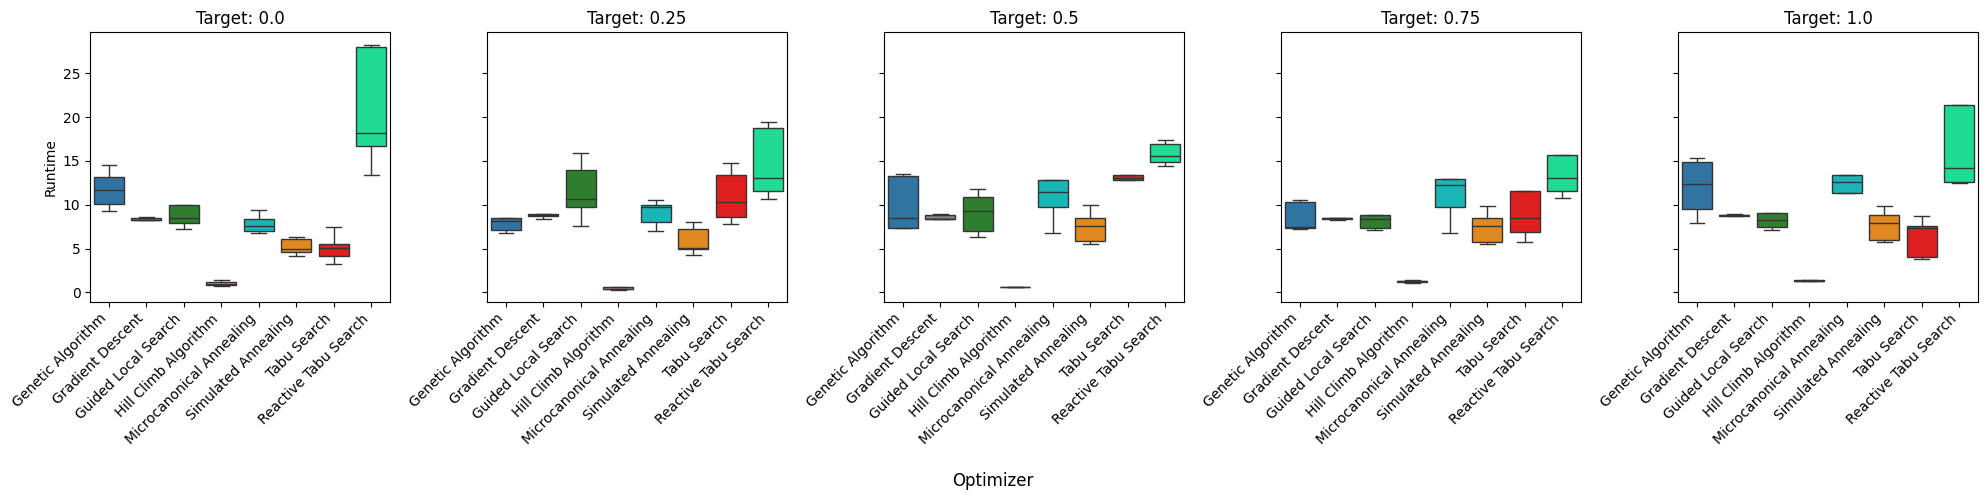

In [49]:
'''-----------------Figure S7-----------------'''

# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

results_df= results_df[results_df['optimizer'] != 'Particle Swarm']

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='runtime',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Runtime')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

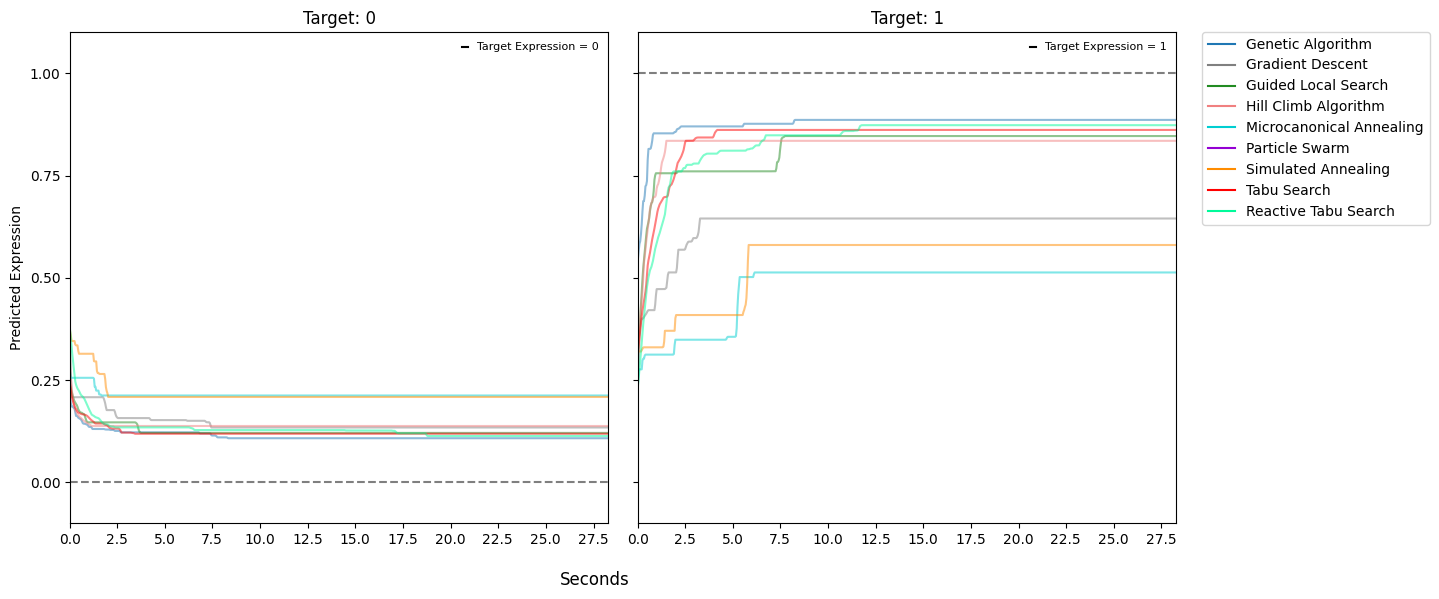

In [50]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()
max_runtime = results_df['runtime'].max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

target_expressions = [0, 1]

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='black', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)
    ax.set_title(f'Target: {target_expr}')

for i in [0, 1]:
    # setting x-ticks to be in seconds
    tick_interval = 2.5
    tick_locs = np.arange(0, max_runtime, tick_interval)
    tick_indices = (tick_locs / max_runtime * max_length).astype(int)

    axes[i].set_xticks(tick_indices)
    axes[i].set_xticklabels([f"{x:.1f}" for x in tick_locs])

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')

fig.supxlabel("Seconds")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
# plt.savefig('Data/Figure 6b.png', dpi=300, bbox_inches='tight')
plt.show()


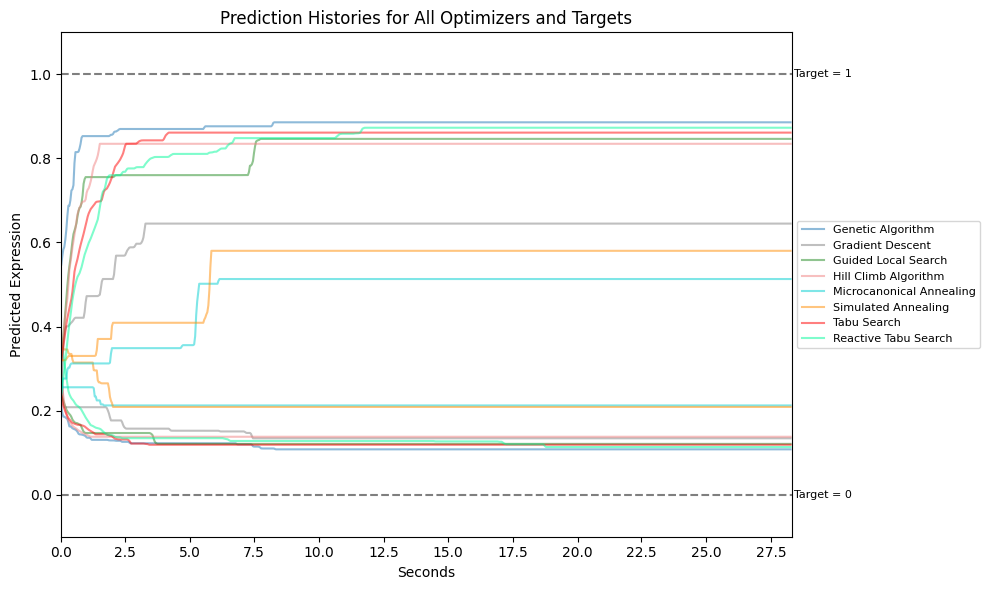

In [51]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()
max_runtime = results_df['runtime'].max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

target_expressions = [0, 1]

# -------------- Combine All Lines Into One Plot --------------

fig, ax = plt.subplots(figsize=(10, 6))

for target_expr in target_expressions:
    for optimizer in optimizer_names:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )

    # Add horizontal line for target expression
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)
    ax.text(max_length + 2, target_expr, f'Target = {target_expr}', va='center', fontsize=8)

ax.set_ylim(-0.1, 1.1)
ax.set_xlim(0, max_length)

# setting x-ticks to be in seconds
tick_interval = 2.5
tick_locs = np.arange(0, max_runtime, tick_interval)
tick_indices = (tick_locs / max_runtime * max_length).astype(int)

ax.set_xticks(tick_indices)
ax.set_xticklabels([f"{x:.1f}" for x in tick_locs])

ax.set_ylabel('Predicted Expression')
ax.set_xlabel('Seconds')
ax.set_title('Prediction Histories for All Optimizers and Targets')

# Deduplicated legend for optimizers
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Remove duplicates
ax.legend(unique.values(), unique.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.tight_layout()
plt.show()


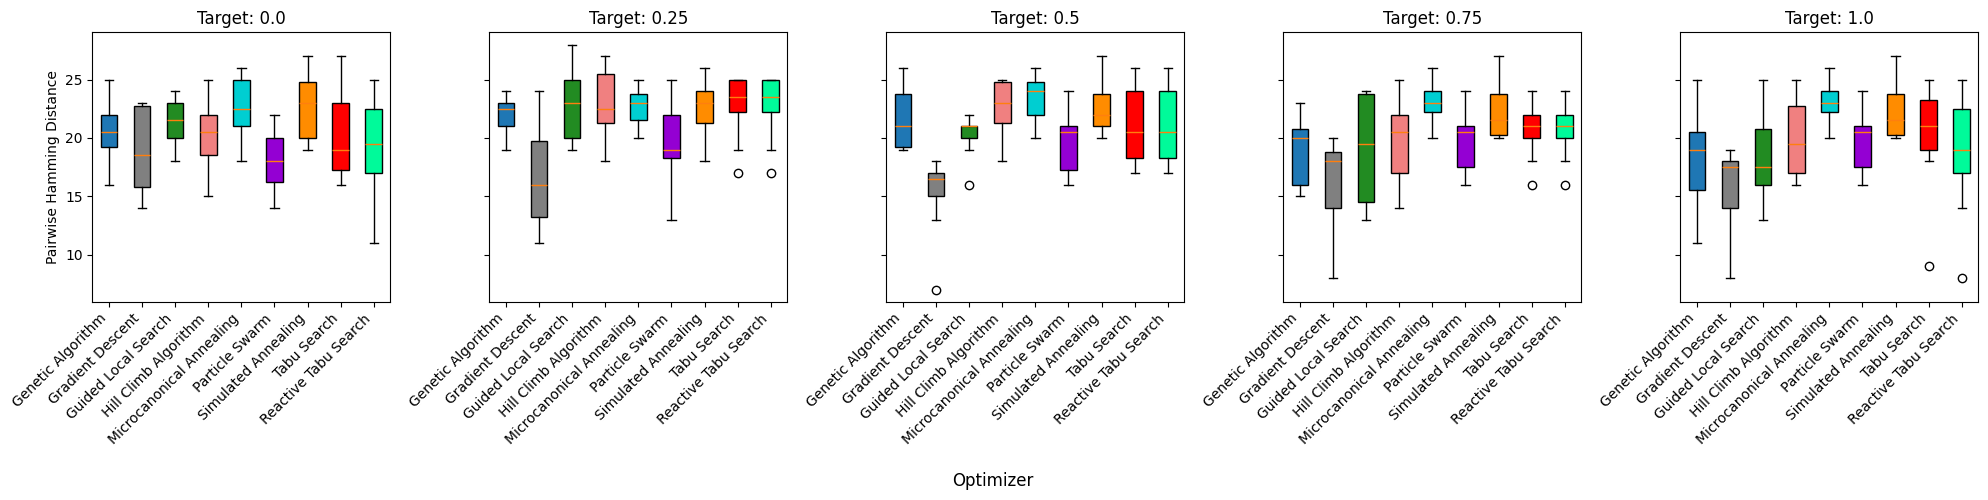

In [52]:
# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

# get optimizer names, but exclude deterministic optimizers
optimizer_names = results_df['optimizer'].unique()

# Plot the boxplot distribution of pairwise hamming distances for every optimizer and target expression combination
for i, target in enumerate(target_expressions):
    ax = axes[i]
    target_df = results_df[results_df['target_expression'] == target]
    
    data_to_plot = []
    
    for opt in optimizer_names:
        opt_df = target_df[target_df['optimizer'] == opt]
        sequences = opt_df['sequence'].values
        hamming_distances = []
        
        for seq1, seq2 in combinations(sequences, 2):
            hamming_distances.append(hamming_distance(seq1, seq2))
        
        data_to_plot.append(hamming_distances)
    
    # Boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Color the boxes
    for patch, opt in zip(bp['boxes'], optimizer_names):
        patch.set_facecolor(color_map[opt])
    
    ax.set_title(f'Target: {target}')
    ax.set_xlabel('')
    ax.set_xticks(range(1, len(optimizer_names) + 1))
    ax.set_xticklabels(optimizer_names, rotation=45, ha='right')

    if i == 0:
        ax.set_ylabel('Pairwise Hamming Distance')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [53]:
def highlight_promoters(s, min_shared=5):
    targets = {
        "TTGACA": "\033[91m",  # Red
        "TATAAT": "\033[92m"   # Green
    }

    # Create a list to store color codes for each character
    highlight_color_map = [("", c) for c in s]

    for i in range(len(s)):
        for target, color in targets.items():
            t_len = len(target)
            if i + t_len <= len(s):
                window = s[i:i + t_len]
                match_positions = [j for j in range(t_len) if window[j] == target[j]]
                if len(match_positions) >= min_shared:
                    for j in match_positions:
                        idx = i + j
                        if highlight_color_map[idx][0] == "":
                            highlight_color_map[idx] = (color, highlight_color_map[idx][1])

    # Build the result string with coloring
    result = ""
    for color, char in highlight_color_map:
        if color:
            result += f"{color}{char}\033[0m"
        else:
            result += char

    return result

# Load and preprocess the data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

results_df = results_df[results_df['target_expression'] == 1]

optimizer_names = ['Genetic Algorithm', 'Reactive Tabu Search', 'Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm']
filtered_df = results_df[results_df['optimizer'].isin(optimizer_names)]

for sequence, optimizer in zip(filtered_df['sequence'], filtered_df['optimizer']):
    highlighted_sequence = highlight_promoters(sequence, min_shared=5)
    print(highlighted_sequence, optimizer)


AATACTAGAGGTCTTCCGACTTGACAACCGGGTTATATTCTATAATAATAGTGTGGGCGGGAAGACAACTAGGGG Genetic Algorithm
AATACTAGAGGTCTTCCGACTTGACTTAAGGGGTATAATTGATATAATCTGTGTGGGCGGGAAGACAACTAGGGG Guided Local Search
AATACTAGAGGTCTTCCGACTTGACAAAACCTATTTTTTTATTATACTAGGTGTGGGCGGGAAGACAACTAGGGG Hill Climb Algorithm
AATACTAGAGGTCTTCCGACTTGACAAAAATGGTAAATTTATTATACTATGTGTGGGCGGGAAGACAACTAGGGG Reactive Tabu Search
AATACTAGAGGTCTTCCGACTTGACAAAACCAGTTCTATTATTATATTATGTGTGGGCGGGAAGACAACTAGGGG Tabu Search


In [54]:
# Load and preprocess the data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

results_df = results_df[results_df['target_expression'] == 1]

optimizer_names = ['Reactive Tabu Search', 'Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm']
filtered_df = results_df[results_df['optimizer'].isin(optimizer_names)]

reference_sequence = filtered_df['sequence'].iloc[0]
for i in range(20, 50):
    print('_' if all(seq[i] == reference_sequence[i] for seq in filtered_df['sequence']) else ' ', end='')
print()

for idx, row in filtered_df.iterrows():
    sequence = row['sequence']
    optimizer = row['optimizer']
    prediction = row['prediction']
    print(sequence[20:50], optimizer)

print('\n---Including GA---\n')

optimizer_names = ['Genetic Algorithm', 'Reactive Tabu Search', 'Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm']
filtered_df = results_df[results_df['optimizer'].isin(optimizer_names)]

reference_sequence = filtered_df['sequence'].iloc[0]
for i in range(20, 50):
    print('_' if all(seq[i] == reference_sequence[i] for seq in filtered_df['sequence']) else ' ', end='')
print()

for idx, row in filtered_df.iterrows():
    sequence = row['sequence']
    optimizer = row['optimizer']
    prediction = row['prediction']
    print(sequence[20:50], optimizer)

print('\n---All Sequences---\n')

optimizer_names = results_df['optimizer'].unique()
filtered_df = results_df[results_df['optimizer'].isin(optimizer_names)]

reference_sequence = filtered_df['sequence'].iloc[0]
for i in range(20, 50):
    print('_' if all(seq[i] == reference_sequence[i] for seq in filtered_df['sequence']) else ' ', end='')
print()

for idx, row in filtered_df.iterrows():
    sequence = row['sequence']
    optimizer = row['optimizer']
    prediction = row['prediction']
    print(sequence[20:50], optimizer)

_____  __    _    __  ____ _  
TTGACTTAAGGGGTATAATTGATATAATCT Guided Local Search
TTGACAAAACCTATTTTTTTATTATACTAG Hill Climb Algorithm
TTGACAAAAATGGTAAATTTATTATACTAT Reactive Tabu Search
TTGACAAAACCAGTTCTATTATTATATTAT Tabu Search

---Including GA---

_____        _    _   __      
TTGACAACCGGGTTATATTCTATAATAATA Genetic Algorithm
TTGACTTAAGGGGTATAATTGATATAATCT Guided Local Search
TTGACAAAACCTATTTTTTTATTATACTAG Hill Climb Algorithm
TTGACAAAAATGGTAAATTTATTATACTAT Reactive Tabu Search
TTGACAAAACCAGTTCTATTATTATATTAT Tabu Search

---All Sequences---

_                             
TTGACAACCGGGTTATATTCTATAATAATA Genetic Algorithm
TTTGCAATTAACCCCTTAAAATGTTAAAAT Gradient Descent
TTGACTTAAGGGGTATAATTGATATAATCT Guided Local Search
TTGACAAAACCTATTTTTTTATTATACTAG Hill Climb Algorithm
TGGCACGGTTAGTATATACTTATACAAATC Microcanonical Annealing
TGGACGGGGGGGACAGGTGTTATACTATGC Particle Swarm
TTGACAAAAATGGTAAATTTATTATACTAT Reactive Tabu Search
TAACCTCGTATACTATCAGTTATCTTTTTT Simulated Annealing
TTGACAAAACCAGT

In [55]:
optimizer_names = ['Genetic Algorithm', 'Reactive Tabu Search', 'Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm']
filtered_df = results_df[results_df['optimizer'].isin(optimizer_names)]

filtered_df = filtered_df.sort_values(by='prediction', ascending=False)

for idx, row in filtered_df.iterrows():
    sequence = row['sequence']
    optimizer = row['optimizer']
    prediction = row['prediction']
    print(f'{prediction:.3f} {sequence[20:50]} {optimizer}')

0.886 TTGACAACCGGGTTATATTCTATAATAATA Genetic Algorithm
0.873 TTGACAAAAATGGTAAATTTATTATACTAT Reactive Tabu Search
0.861 TTGACAAAACCAGTTCTATTATTATATTAT Tabu Search
0.847 TTGACTTAAGGGGTATAATTGATATAATCT Guided Local Search
0.835 TTGACAAAACCTATTTTTTTATTATACTAG Hill Climb Algorithm


In [59]:
from generators.CNN import CNN

cnn = CNN(kwargs['cnn_model_path'])

up = 'AATACTAGAGGTCTTCCGAC'
down = 'GTGTGGGCGGGAAGACAACTAGGGG'

seq = [
    'TTGACAAAAATGGTAAATTTATTATACTAT', # Reactive Tabu Search
    'TTGACAAAAATGGTAAATTTATTATAATAT', # Reactive Tabu Search (-10)
    'TTGACAAAAATGGTAAATTTTATAATAAAT', # Reactive Tabu Search (GA -10)
    'TTGACAAAACCAGTTCTATTATTATATTAT', # Tabu Search
    'TTGACAAAACCAGTTCTATTATTATAATAT', # Tabu Search (-10)
    'TTGACAAAACCAGTTCTATTTATAATAAAT', # Tabu Search (GA -10)
    'TTGACAAAACCTATTTTTTTATTATACTAG', # Hill Climb Algorithm
    'TTGACAAAACCTATTTTTTTATTATAATAG', # Hill Climb Algorithm (-10)
    'TTGACAAAACCTATTTTTTTTATAATAAAG', # Hill Climb Algorithm (GA -10)

]
seq = [up + s + down for s in seq]

seq = cnn.preprocess(seq)
pred = cnn.predict(seq)

# iterate ever other element in the list and print the prediction
for i in range(0, len(pred), 3):
    # print(pred[i] - pred[i + 1]) # origin vs -10
    print(pred[i] - pred[i + 2]) # origin vs GA -10

0.024309814
0.014202416
0.039753318


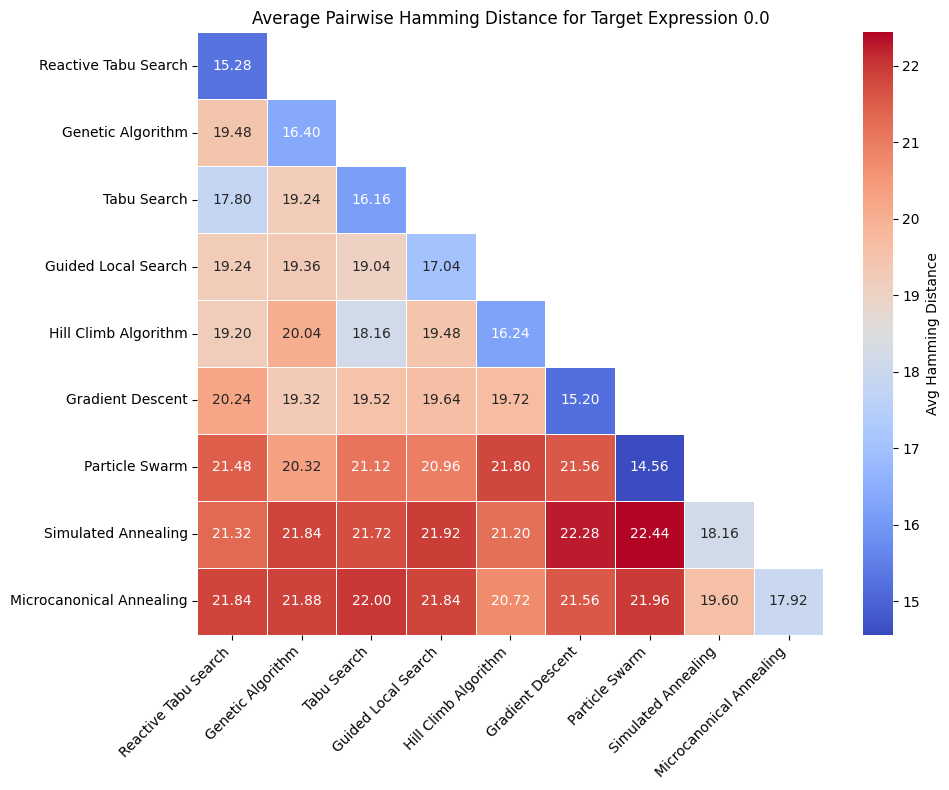

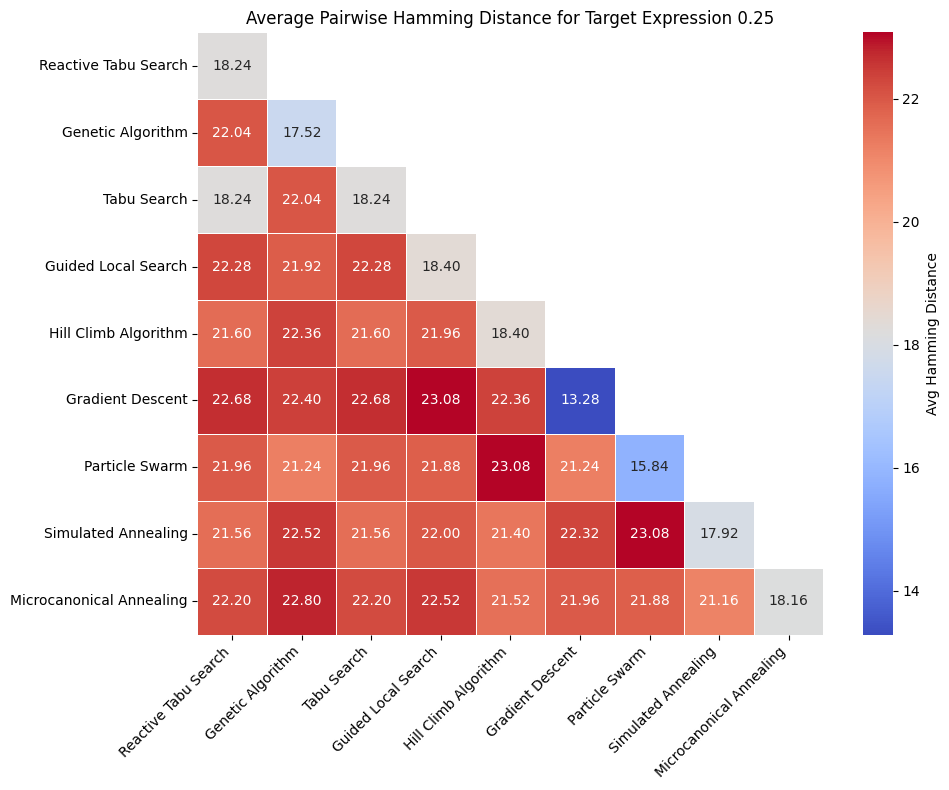

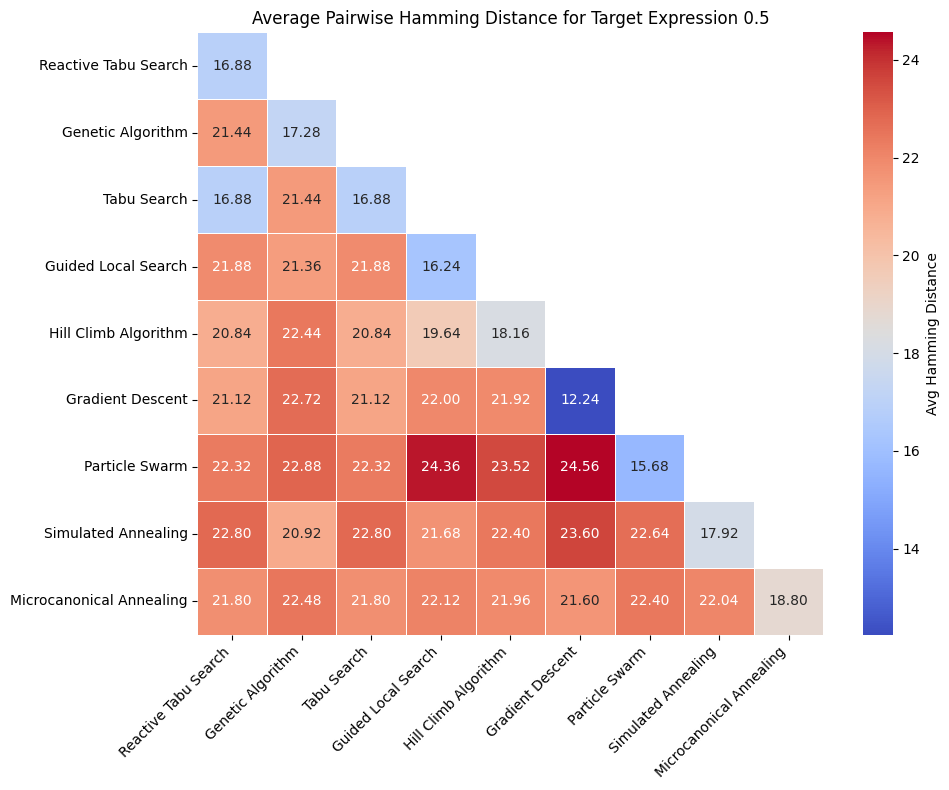

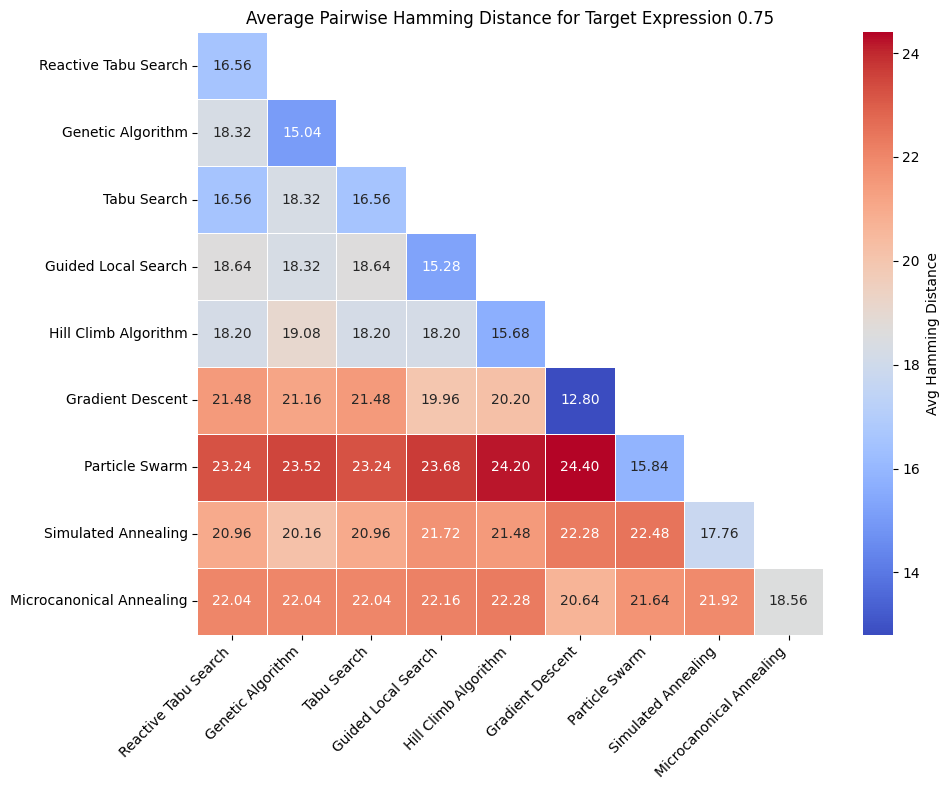

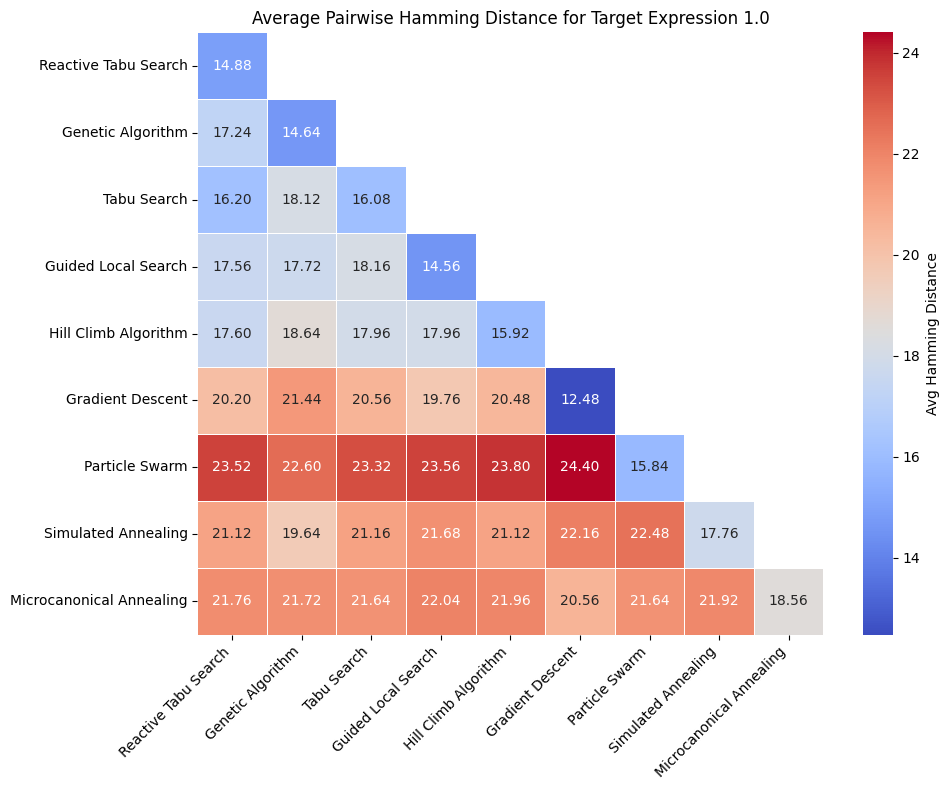

In [60]:
# Load and preprocess data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

target_expressions = results_df['target_expression'].unique()

# Determine global optimizer order by mean error
global_error_means = results_df.groupby('optimizer')['error'].mean()
global_sorted_optimizers = global_error_means.sort_values().index.tolist()

hamming_dfs = {}

# Compute average Hamming distance for all pairs of optimizers (including self-pairs)
for target in target_expressions:
    target_df = results_df[results_df['target_expression'] == target]

    hamming_matrix = pd.DataFrame(index=global_sorted_optimizers, columns=global_sorted_optimizers, dtype=float)

    for opt1, opt2 in product(global_sorted_optimizers, repeat=2):
        seqs1 = target_df[target_df['optimizer'] == opt1]['sequence'].tolist()
        seqs2 = target_df[target_df['optimizer'] == opt2]['sequence'].tolist()

        distances = []
        for s1 in seqs1:
            for s2 in seqs2:
                distances.append(hamming_distance(s1, s2))

        if distances:
            avg_distance = np.mean(distances)
        else:
            avg_distance = np.nan

        hamming_matrix.loc[opt1, opt2] = avg_distance

    hamming_dfs[target] = hamming_matrix

# Plot the Hamming distance matrices
for target, hamming_df in hamming_dfs.items():
    mask = np.triu(np.ones_like(hamming_df, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        hamming_df,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Avg Hamming Distance'}
    )
    plt.title(f'Average Pairwise Hamming Distance for Target Expression {target}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [61]:
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

results_df = best_tests(results_df)

min_error_preds = results_df.drop_duplicates(subset=['optimizer', 'target_expression'], keep='first')

pivot_df = min_error_preds.pivot(
    index='optimizer',
    columns='target_expression',
    values='prediction'
)

pivot_df.columns = [f'prediction (target_expression={col})' for col in pivot_df.columns]
pivot_df = pivot_df.sort_values(by=pivot_df.columns[-1], ascending=False)
pivot_df = pivot_df.reset_index()

pivot_df


optimizer  prediction (target_expression=0.0)  \
0         Genetic Algorithm                            0.107874   
1      Reactive Tabu Search                            0.113416   
2               Tabu Search                            0.118780   
3       Guided Local Search                            0.120862   
4      Hill Climb Algorithm                            0.137827   
5          Gradient Descent                            0.134133   
6            Particle Swarm                            0.181424   
7       Simulated Annealing                            0.208723   
8  Microcanonical Annealing                            0.212349   

   prediction (target_expression=0.25)  prediction (target_expression=0.5)  \
0                             0.249999                            0.500000   
1                             0.250000                            0.500001   
2                             0.250000                            0.500001   
3                             0.250002                            0.499996   
4                             0.250009                            0.500015   
5                             0.249784                            0.487831   
6                             0.250005                            0.499646   
7                             0.250161                            0.507794   
8                             0.250067                            0.501824   

   prediction (target_expression=0.75)  prediction (target_expression=1.0)  
0                             0.749995                            0.885947  
1                             0.750004                            0.873045  
2                             0.750004                            0.861419  
3                             0.750144                            0.846510  
4                             0.749663                            0.834812  
5                             0.644957                            0.644957  
6                             0.586647                            0.586647  
7                             0.580200                            0.580200  
8                             0.513064                            0.513064

### Figures 
---

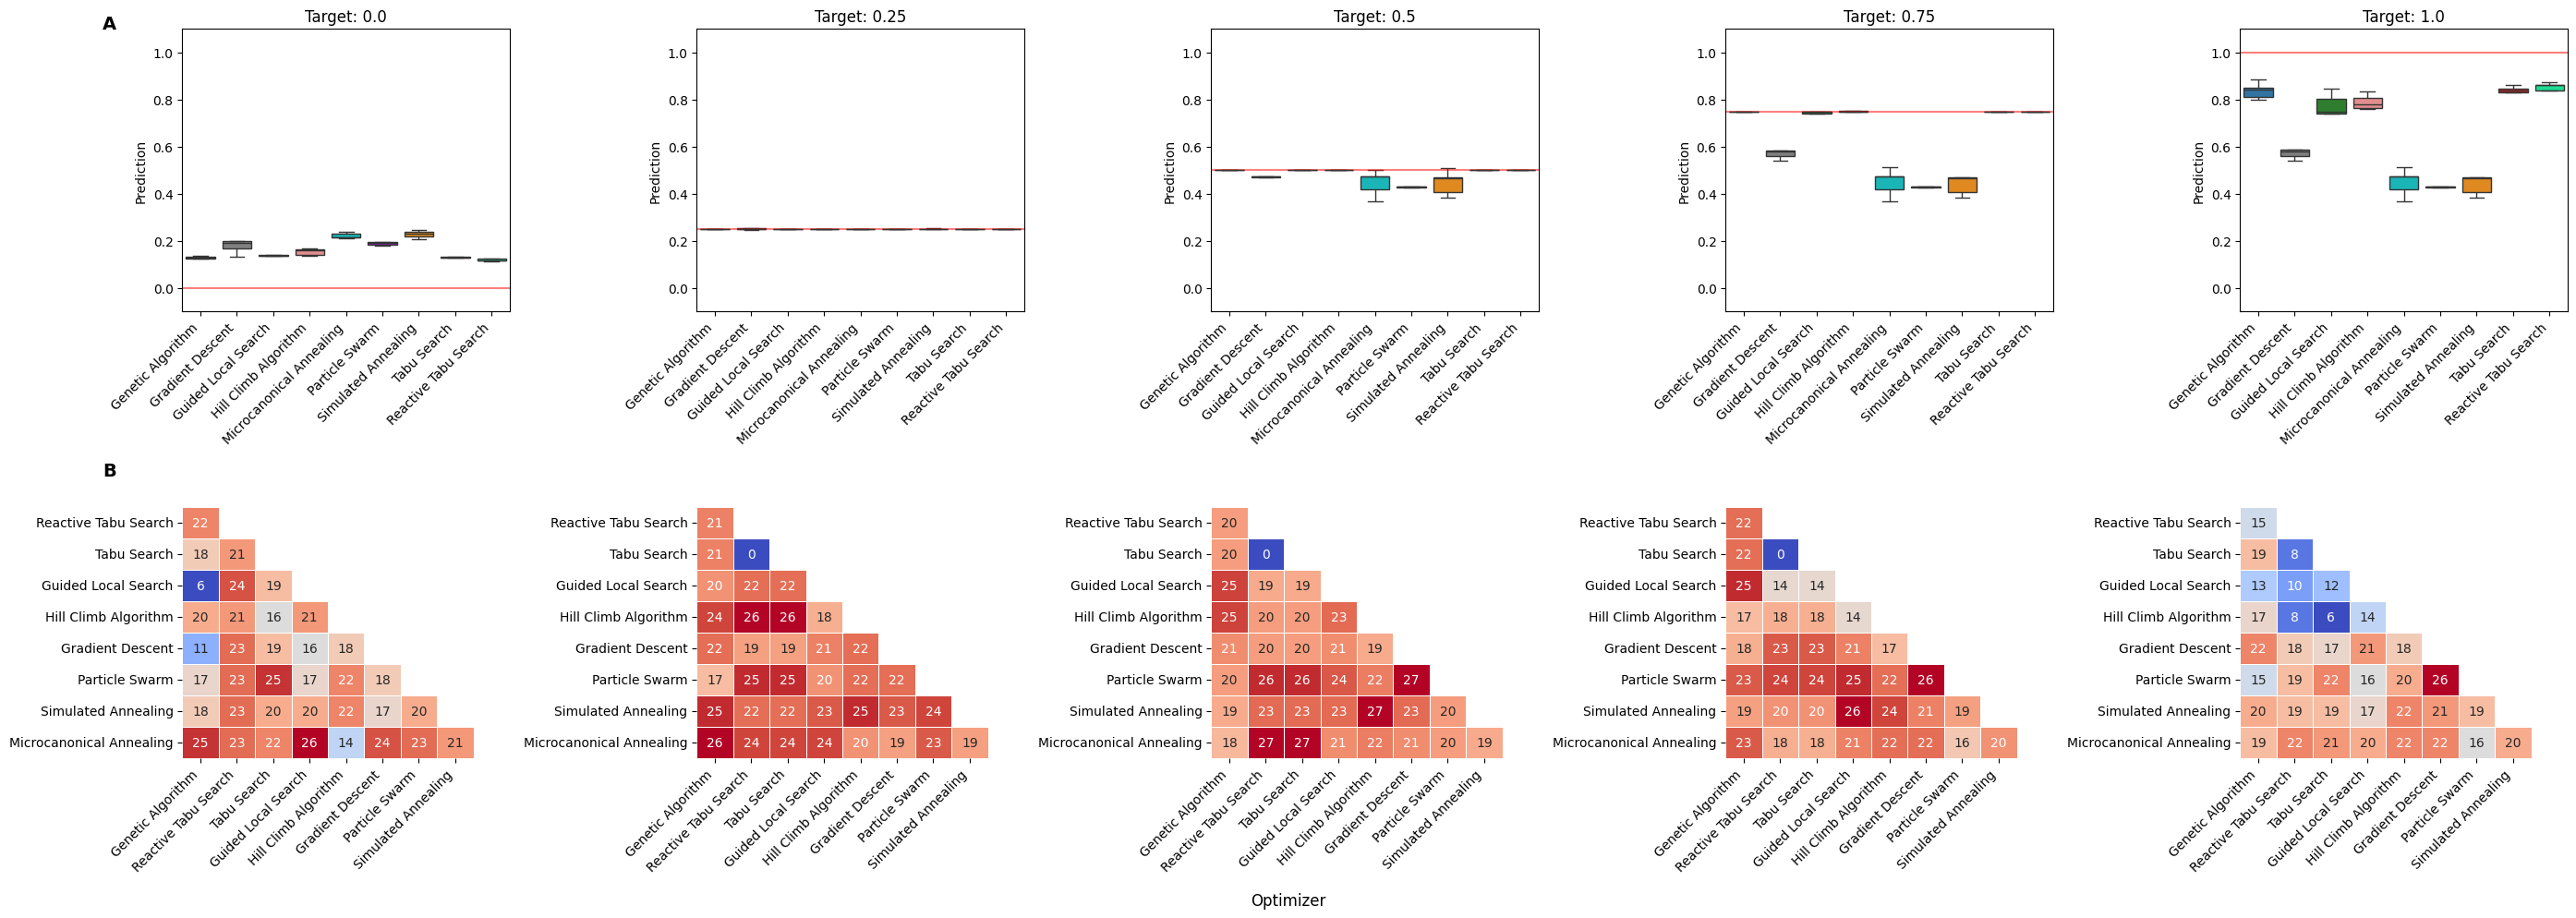

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from itertools import product

# -----------------Load & preprocess shared data-----------------
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
optimizer_names = results_df['optimizer'].unique()
target_expressions = results_df['target_expression'].unique()

# -----------------Prepare Data for Figure 6B-----------------
def best_tests(df):
    grouped = df.groupby(['optimizer', 'target_expression'])
    best_rows = []
    for (optimizer, target), group in grouped:
        best_error_idx = group['error'].idxmin()
        best_row = group.loc[best_error_idx]
        best_rows.append({
            'optimizer': optimizer,
            'target_expression': target,
            'sequence': best_row['sequence'],
            'prediction': best_row['prediction'],
            'error': best_row['error'],
            'runtime': best_row['runtime'],
            'prediction_history': best_row['prediction_history'],
            'error_history': best_row['error_history'],
        })
    return pd.DataFrame(best_rows)

def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Convert string to list
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Extract best tests
best_df = best_tests(results_df)

# Compute sorted optimizer list for heatmap order
global_error_means = best_df.groupby('optimizer')['error'].mean()
global_sorted_optimizers = global_error_means.sort_values().index.tolist()

# Precompute Hamming distance matrices
hamming_dfs = {}
for target in target_expressions:
    target_df = best_df[best_df['target_expression'] == target]
    hamming_matrix = pd.DataFrame(index=global_sorted_optimizers, columns=global_sorted_optimizers, dtype=float)

    for opt1, opt2 in product(global_sorted_optimizers, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            try:
                seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
                seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
                hamming_matrix.loc[opt1, opt2] = hamming_distance(seq1, seq2)
            except IndexError:
                hamming_matrix.loc[opt1, opt2] = np.nan

    hamming_dfs[target] = hamming_matrix

# -----------------Plot Combined Figure-----------------
fig, axes = plt.subplots(2, 5, figsize=(28, 10), gridspec_kw={'height_ratios': [1, 1]})
axes = axes.reshape(2, 5)

# ---- Top Row: Boxplots ----
for i, target_expr in enumerate(target_expressions):
    ax = axes[0, i]
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=ax,
        palette=color_map,
        showfliers=False
    )
    ax.set_title(f'Target: {target_expr}')
    ax.set_xlabel('')
    ax.set_ylabel('Prediction')
    ax.set_xticks(range(len(optimizer_names)))
    ax.set_xticklabels(optimizer_names, rotation=45, ha='right')

    # Horizontal line for the target value
    ax.axhline(y=target_expr, color='red', linestyle='-', alpha=0.5, label='Target Expression')

    ax.set_ylim(-0.1, 1.1)

# ---- Bottom Row: Heatmaps ----
for i, target_expr in enumerate(target_expressions):
    ax = axes[1, i]
    hamming_df = hamming_dfs[target_expr]
    mask = np.triu(np.ones_like(hamming_df, dtype=bool))

    sns.heatmap(
        hamming_df,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        linewidths=0.5,
        cbar=False,
        ax=ax
    )

    # Remove the last x-tick label since it's masked
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    ax.set_xticks(xticks[:-1])
    ax.set_xticklabels([label.get_text() for label in xticklabels[:-1]], rotation=45, ha='right')

    # Remove the first y-tick label since it's masked
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks[1:])
    ax.set_yticklabels([label.get_text() for label in yticklabels[1:]])

# Figure text labels
axes[0, 0].text(-0.2, 1.05, "A", transform=axes[0, 0].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')
axes[1, 0].text(-0.2, 1.05, "B", transform=axes[1, 0].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

# Layout adjustments
fig.supxlabel("Optimizer")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


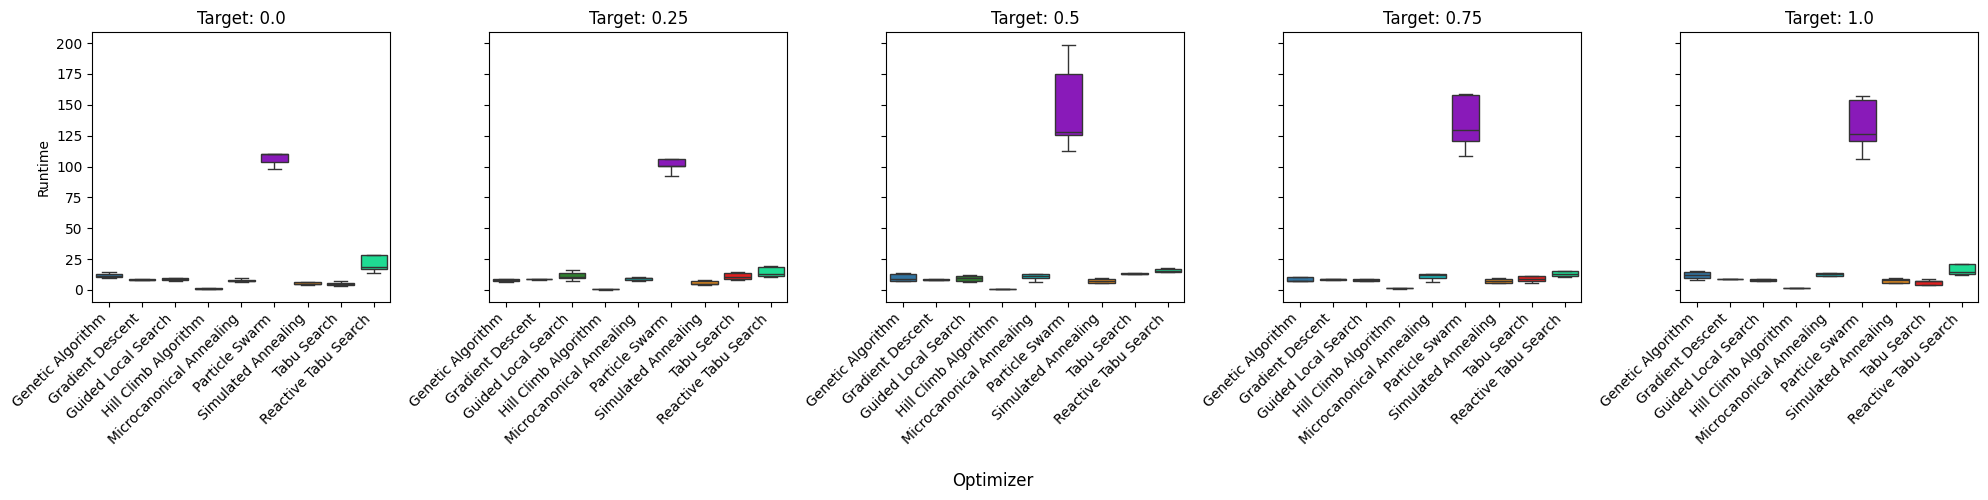

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

'''-----------------Figure S6-----------------'''

# Load data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

optimizer_names = results_df['optimizer'].unique()

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='runtime',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Runtime')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

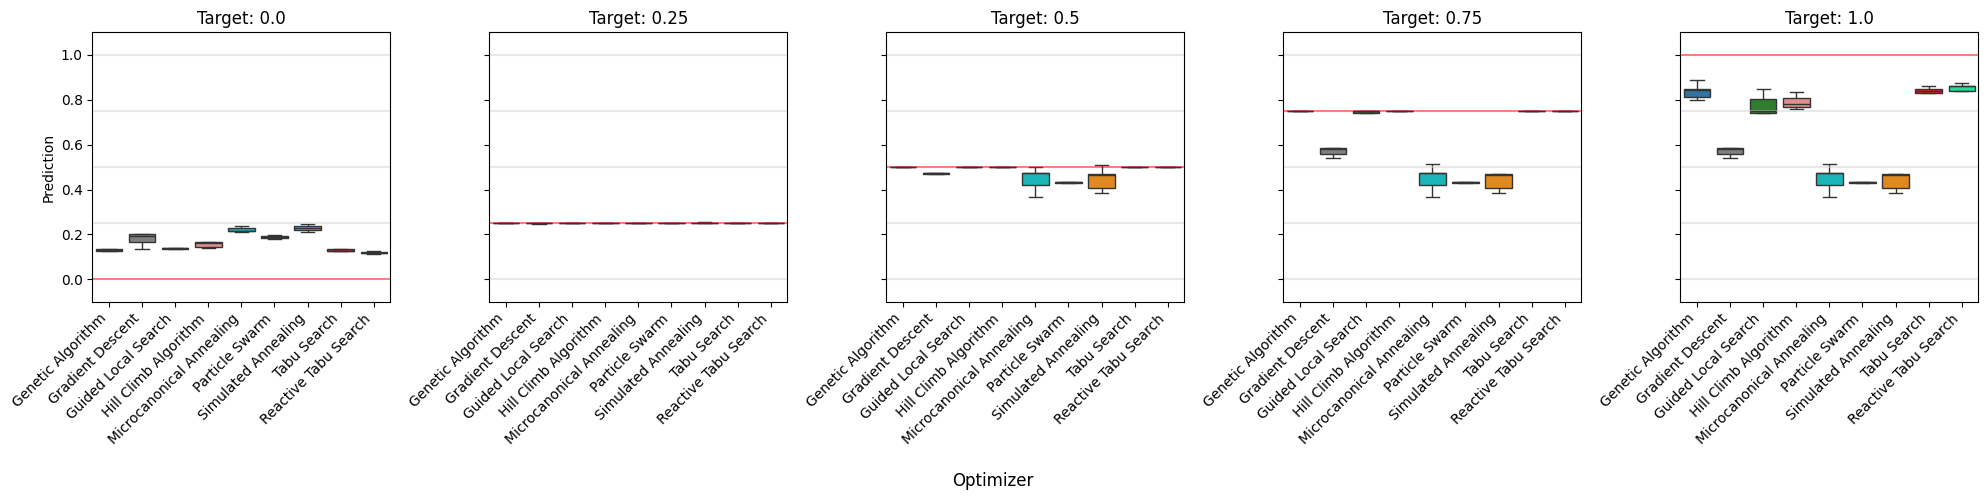

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

'''-----------------Figure 6A-----------------'''

results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prediction')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        label = f'Target Expression = {each}' if each == target_expr else None
        axes[i].axhline(y=each, color=color, linestyle='-', alpha=0.5, label=label)

    axes[i].set_ylim(-0.1, 1.1)
    
fig.supxlabel("Optimizer")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

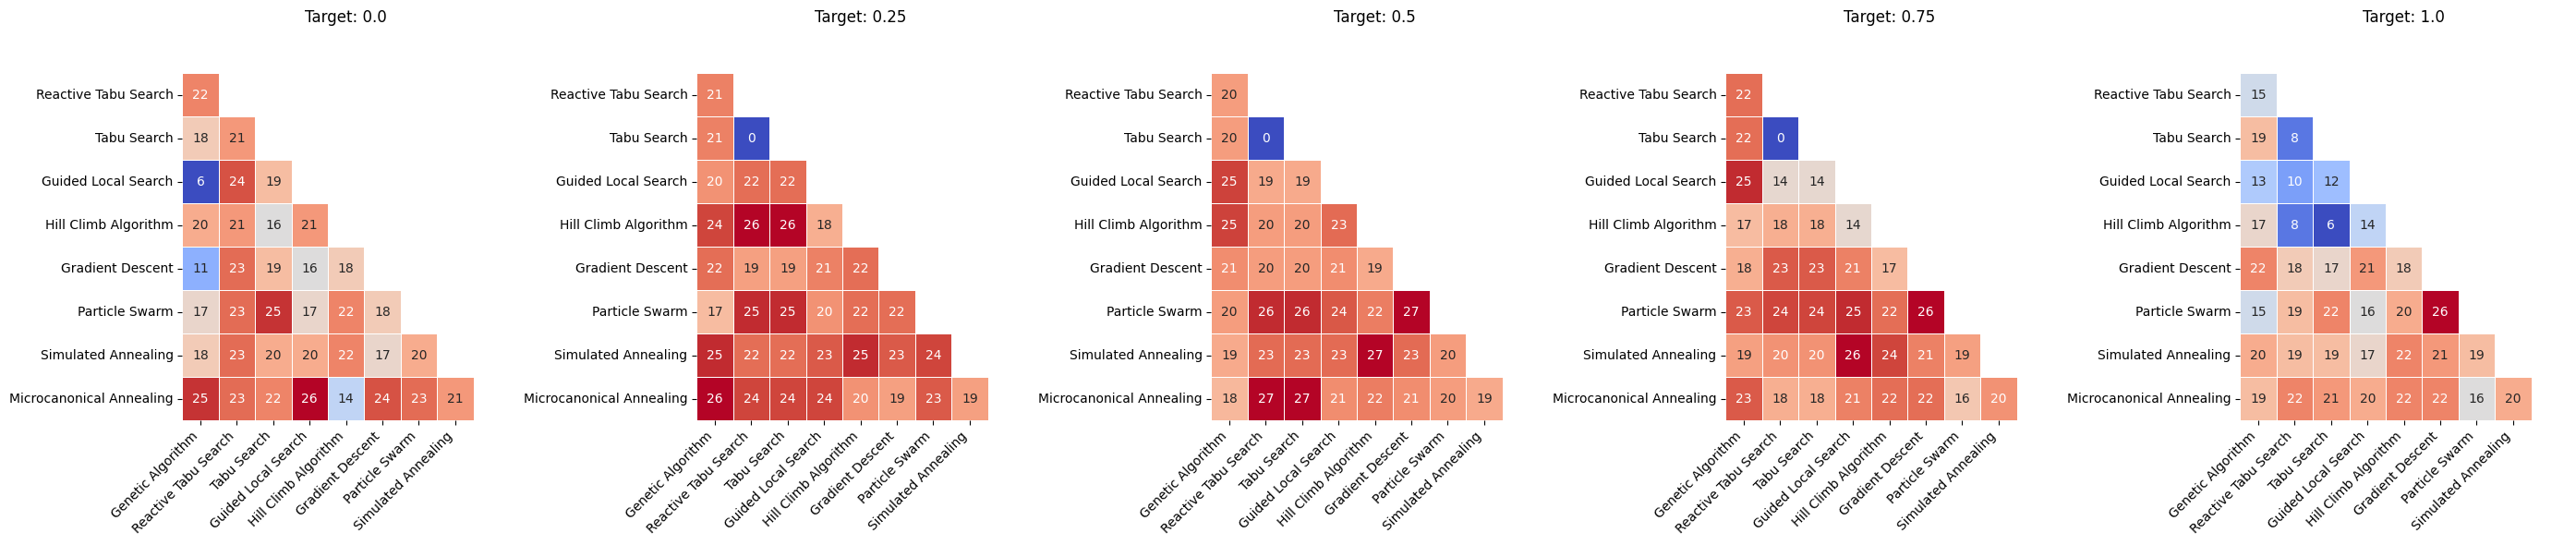

In [65]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import ast

'''-----------------Figure 6B-----------------'''

def best_tests(df):
    grouped = df.groupby(['optimizer', 'target_expression'])
    best_rows = []
    for (optimizer, target), group in grouped:
        best_error_idx = group['error'].idxmin()
        best_row = group.loc[best_error_idx]

        best_rows.append({
            'optimizer': optimizer,
            'target_expression': target,
            'sequence': best_row['sequence'],
            'prediction': best_row['prediction'],
            'error': best_row['error'],
            'runtime': best_row['runtime'],
            'prediction_history': best_row['prediction_history'],
            'error_history': best_row['error_history'],
        })
    return pd.DataFrame(best_rows)

def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Load and preprocess the data
results_df = pd.read_csv('../data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

target_expressions = results_df['target_expression'].unique()

# Define global optimizer order based on overall mean error
global_error_means = results_df.groupby('optimizer')['error'].mean()
global_sorted_optimizers = global_error_means.sort_values().index.tolist()

hamming_dfs = {}

# calculate the hamming distance for each target expression
for target in target_expressions:
    target_df = results_df[results_df['target_expression'] == target]

    hamming_matrix = pd.DataFrame(index=global_sorted_optimizers, columns=global_sorted_optimizers, dtype=float)

    for opt1, opt2 in product(global_sorted_optimizers, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            try:
                seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
                seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
                distance = hamming_distance(seq1, seq2)
                hamming_matrix.loc[opt1, opt2] = distance
            except IndexError:
                hamming_matrix.loc[opt1, opt2] = np.nan

    hamming_dfs[target] = hamming_matrix

fig, axes = plt.subplots(1, 5, figsize=(28, 6), squeeze=False)

for i, (target, hamming_df) in enumerate(hamming_dfs.items()):
    mask = np.triu(np.ones_like(hamming_df, dtype=bool))

    ax = axes[0, i]
    sns.heatmap(
        hamming_df,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        linewidths=.5,
        cbar=False,
        ax=ax
    )

    # Remove the last x-tick label since it's masked
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    ax.set_xticks(xticks[:-1])
    ax.set_xticklabels([label.get_text() for label in xticklabels[:-1]], rotation=45, ha='right')

    # Remove the first y-tick label since it's masked
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks[1:])
    ax.set_yticklabels([label.get_text() for label in yticklabels[1:]])

    ax.set_title(f'Target: {target}')

plt.tight_layout()
plt.show()
